In [19]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal # we will also import the signal module, from scipy
import scipy as sp
from mpl_toolkits import mplot3d

# Load Datasets

In [20]:
ECoG_monkey = io.loadmat('./project_data/ECoG_monkey/ECoG_monkey.mat', squeeze_me=True)

# Analysis Tool box

In [21]:
class ECoG_data:
# (c++)Private:
# static methods(Local scope helper methods): 
    def compute_power_phase(x_a):
        return np.abs(x_a)**2, np.angle(x_a)
    
    def slide_window_time(T, len_win, len_overlap):
        t_steps = np.arange(0, T, (len_win - len_overlap))
        return t_steps[t_steps <= (T - len_win)]

    def slide_window_index(T, fs, len_win, len_overlap):
        return (ECoG_data.slide_window_time(T, len_win, len_overlap) * fs).astype(int)

    # plotter for Spectrogram
    def plot_spg(spg, t, f, freq_lims=[0,100], plot_db=False):
        """
        Utility function for plotting the spectrogram for you.

        spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
        t: time axis of spectrogram
        f: frequency axis of spectrogram
        freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
        """
        plt.figure(figsize=(15,4))
        if plot_db:
            plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
        else:
            plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
        plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
        plt.ylim(freq_lims)
        plt.colorbar()
        plt.tight_layout()

# (c++)Public:  
# instance methods:

    #constructor, time vector is created here to be used throughout the notebook
    def __init__(self, name, dataset_matlab_format):
        self.name = name
        self.dataset = dataset_matlab_format
        self.fs = self.dataset['fs']
        self.labels = self.dataset['labels']
        self.anes = self.dataset['ecog_anes']
        self.eyes_open = self.dataset['ecog_eyesopen']
        self.eyes_closed = self.dataset['ecog_eyesclosed']
        self.len = min(self.anes.shape[1], 
                       self.eyes_closed.shape[1], 
                       self.eyes_open.shape[1])
        self.time_vec = np.arange(0, self.len/self.fs, 1/self.fs)
        
    #plotter for one of the 3 data subsets: (dataset).anes, (dataset).eyes_open, (dataset).eyes_closed 
    def plot(self, subset_name, data_subset, x_range = [0,10], y_range = None):
        plt.figure(figsize=(20,3))
        for label_idx in range(len(self.labels)):
            plt.plot(self.time_vec, data_subset[label_idx], label = self.labels[label_idx])
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Time (s)')
        plt.legend()
        plt.title(subset_name)
    
    #Signal(1D Array) getter to fetch the particular dataArray indexed by the one of the 3 Cortical locations: 
    #Cingulate, Occipital, Temporal 
    def signal(self, data_subset, cortical_location_label):
        return data_subset[np.where(monkey.labels == cortical_location_label)].squeeze()
    
    #Helper method to plot one signal
    def plot_signal(self, signal_name, signal, x_range = None, y_range = None):
        plt.figure(figsize=(20,3))
        plt.plot(self.time_vec, signal)
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Time (s)')
        plt.title(signal_name)

    #Helper method to plot a LIST of signals
    def plot_signals(self, signals, labels, x_range = None, y_range = None, loglog = False):
        plt.figure(figsize=(20,6))
        i = 0
        for label in labels:
            if loglog == True:
                plt.loglog(self.time_vec, signals[i], label = label)
            else:
                plt.plot(self.time_vec, signals[i], label = label)
            i+=1
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Time (s)')
        plt.legend()


    # Discrete Fourier Transform
    def fft(self, signal):
        freqs = np.fft.fftfreq(len(signal), 1/self.fs)
        fft_phasor = np.fft.fft(signal)
        return freqs, fft_phasor
    
    # Plot the power spectrum of one particular signal
    def plot_power_spectrum(self, signal_name, signal, x_range = None, y_range = None):
        plt.figure(figsize=(20,3))
        
        freqs, phasor = self.fft(signal)
        power, phase = ECoG_data.compute_power_phase(phasor)
        plt.plot(freqs, power, '.')
    
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (mV^2)')
        #plt.legend()
        plt.title(signal_name)
       
    # my_stft from A3
    def my_stft(self, signal, fs, len_win, len_overlap):
        T = len(signal)/fs 
        inds_stft = ECoG_data.slide_window_index(T, fs, len_win, len_overlap)
        t_stft = ECoG_data.slide_window_time(T, len_win, len_overlap)
        f_stft = np.fft.fftfreq(int(fs*len_win), 1/fs)
        stft = np.array([np.fft.fft(signal[i:i+int(fs*len_win)]) for i in inds_stft]).T
        # clip the frequency axis to return just the non-negative frequencies
        # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
        positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)    
        return list([abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :] ])

    
    def plot_spectrogram(self, signal_name, stft_rtn, freq_range=[0,50], plot_db=False):
        [f_stft, t_stft, stft] = stft_rtn
        spg = np.abs(stft/self.fs)**2
        ECoG_data.plot_spg(spg, t_stft, f_stft, freq_range, plot_db)
        plt.title(signal_name)
        
    def plot_PSD(self, signal_name, stft_rtn, x_range = None, y_range = None):
        f_stft, t_stft, stft = stft_rtn
        spg = np.abs(stft/self.fs)**2
        plt.figure(figsize=(10,6))
        plt.plot(f_stft, spg.mean(axis=1), 'o-')
        
        if y_range != None:
            plt.ylim(y_range)
        if x_range != None:
            plt.xlim(x_range)
            
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Density (mV^2/Hz)')
        plt.title(signal_name)
        
    # plot all 3 PSD in one figure for easier comparison    
    def plot_PSD_all(self, stfts, labels, x_range = None, y_range = None, loglog = False):
        plt.figure(figsize=(15,6))
        if x_range != None:
            plt.xlim(x_range)
        if y_range != None:
            plt.ylim(y_range)
        
        i = 0
        for label in labels:
            [f_stft, t_stft, stft] = stfts[i]
            spg = np.abs(stft/self.fs)**2
            if loglog == True:
                plt.loglog(f_stft, spg.mean(axis=1), 'o-', label = label)
            else:
                plt.plot(f_stft, spg.mean(axis=1), 'o-', label = label)
            i += 1
            
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Density (mV^2/Hz)')
        plt.legend()
    
    def band_pass_filter(self, signal, band, num_points = 1000):
        fir = sp.signal.firwin(num_points, band, fs=self.fs, pass_zero=False)
        return np.convolve(signal, fir, mode='same')
        

# Instantiate    
monkey = ECoG_data("monkey_curated", ECoG_monkey)

In [22]:
print("fs = ", monkey.fs, "Hz")
print("labels = ", monkey.labels)
print("Anesthetized data shape = ", monkey.anes.shape)
print("Awake Eyes Opened data shape = ", monkey.eyes_open.shape)
print("Awake Eyes Closed data shape = ", monkey.eyes_closed.shape)
print("Minimum length of the available data = ", monkey.len)
print("Length of the corresponding time vector = ", len(monkey.time_vec))
print("Sampling period = ", monkey.time_vec[1] - monkey.time_vec[0], "sec")

fs =  1000 Hz
labels =  ['cingulate' 'occipital' 'temporal']
Anesthetized data shape =  (3, 300000)
Awake Eyes Opened data shape =  (3, 300000)
Awake Eyes Closed data shape =  (3, 300000)
Minimum length of the available data =  300000
Length of the corresponding time vector =  300000
Sampling period =  0.001 sec


# Real Signals in Time Domain

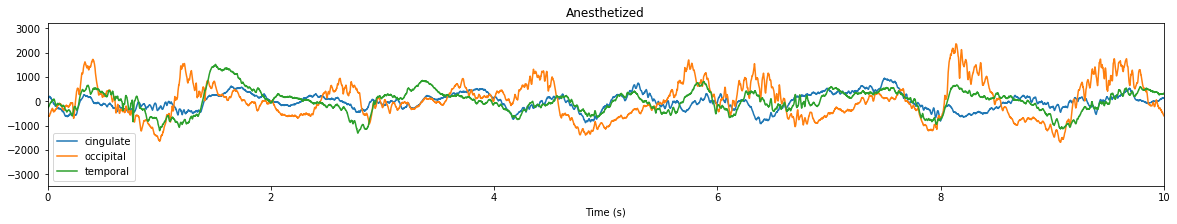

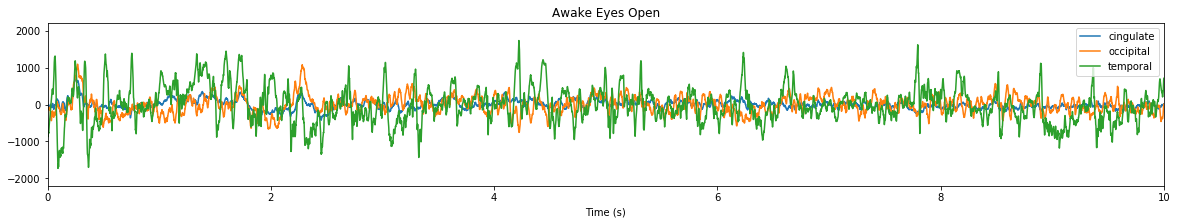

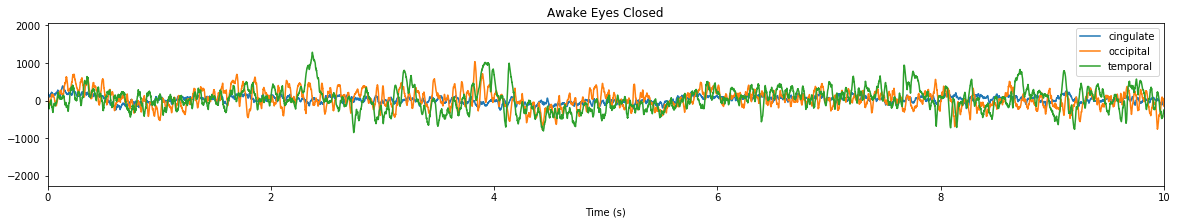

In [23]:
monkey.plot("Anesthetized", monkey.anes)
monkey.plot("Awake Eyes Open", monkey.eyes_open)
monkey.plot("Awake Eyes Closed", monkey.eyes_closed)

# Discrete Fourier Transform

## Power Spectrum of Cingulate Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

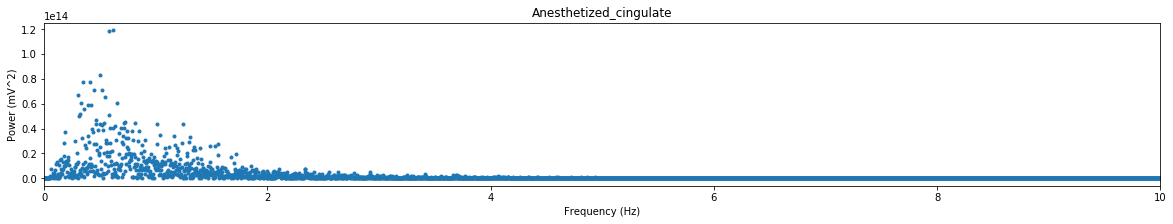

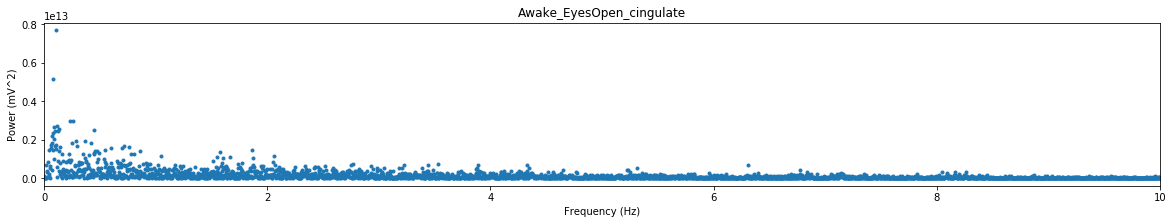

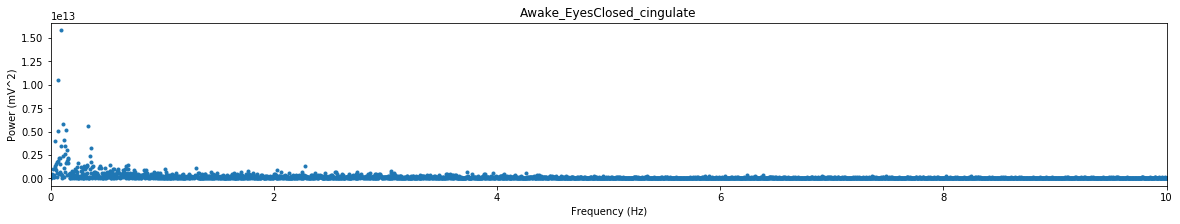

In [24]:
monkey.plot_power_spectrum("Anesthetized_cingulate", monkey.signal(monkey.anes, 'cingulate'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_cingulate", monkey.signal(monkey.eyes_open, 'cingulate'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_cingulate", monkey.signal(monkey.eyes_closed, 'cingulate'), x_range = [0, 10])

## Power Spectrum of Occipital Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

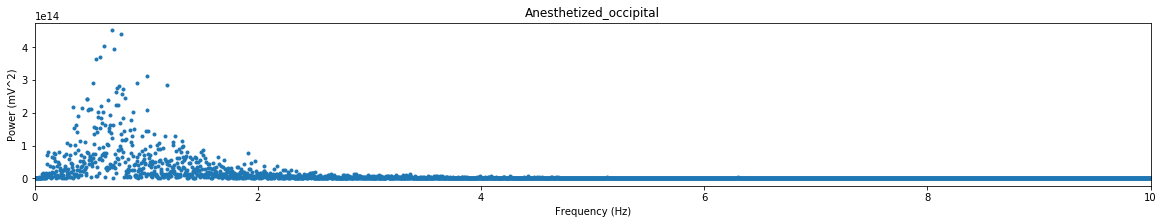

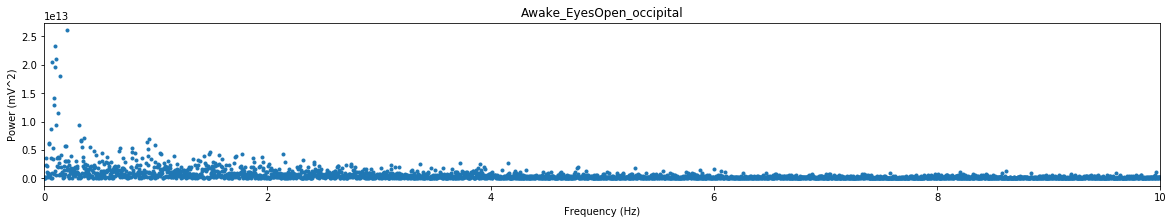

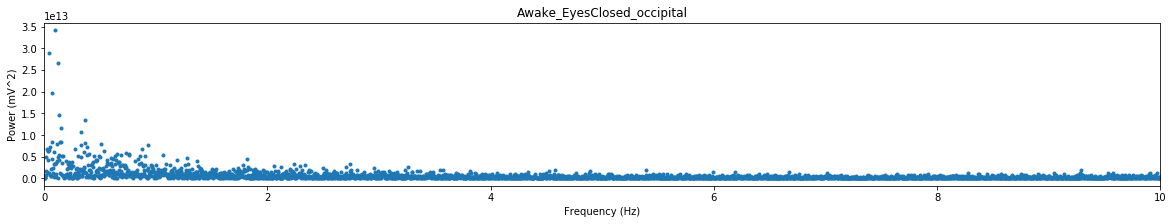

In [25]:
monkey.plot_power_spectrum("Anesthetized_occipital", monkey.signal(monkey.anes, 'occipital'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_occipital", monkey.signal(monkey.eyes_open, 'occipital'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_occipital", monkey.signal(monkey.eyes_closed, 'occipital'), x_range = [0, 10])

## Power Spectrum of Temporal Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

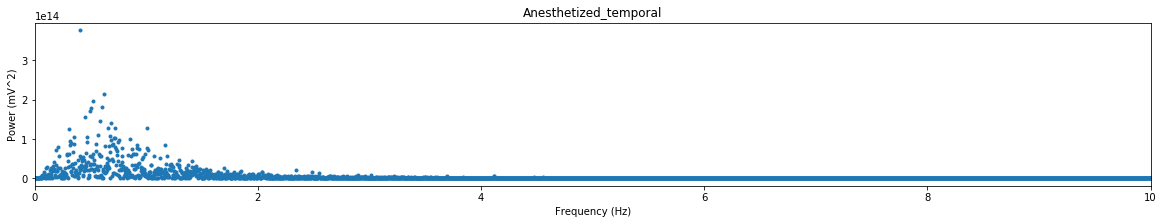

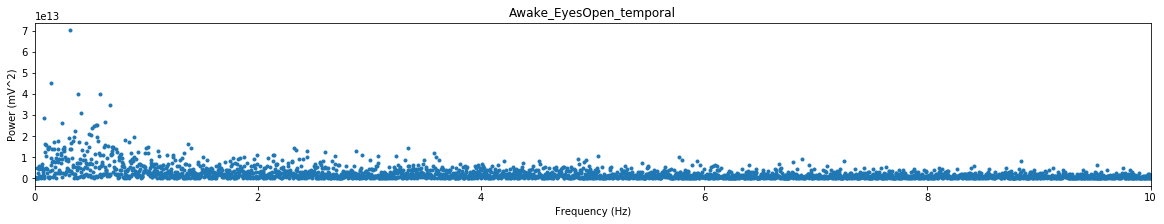

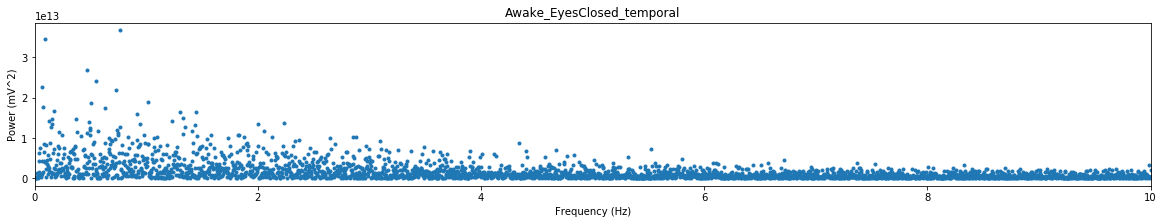

In [26]:
monkey.plot_power_spectrum("Anesthetized_temporal", monkey.signal(monkey.anes, 'temporal'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesOpen_temporal", monkey.signal(monkey.eyes_open, 'temporal'), x_range = [0, 10])
monkey.plot_power_spectrum("Awake_EyesClosed_temporal", monkey.signal(monkey.eyes_closed, 'temporal'), x_range = [0, 10])

# Power Spectrogram & Power Spectral Density 

## PS & PSD of Cingulate Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

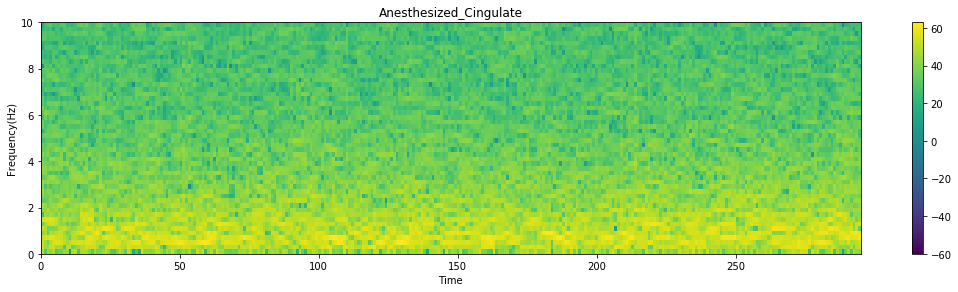

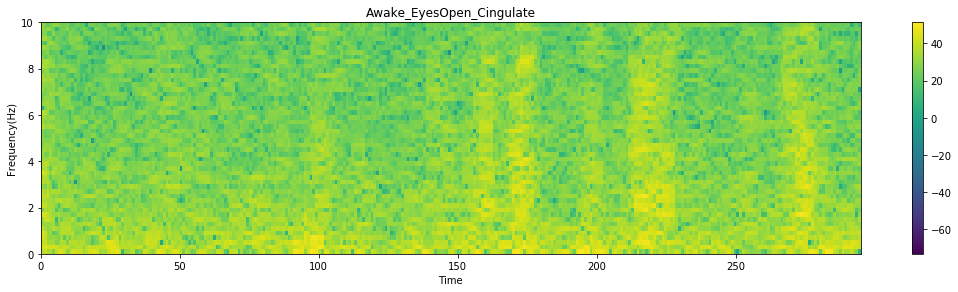

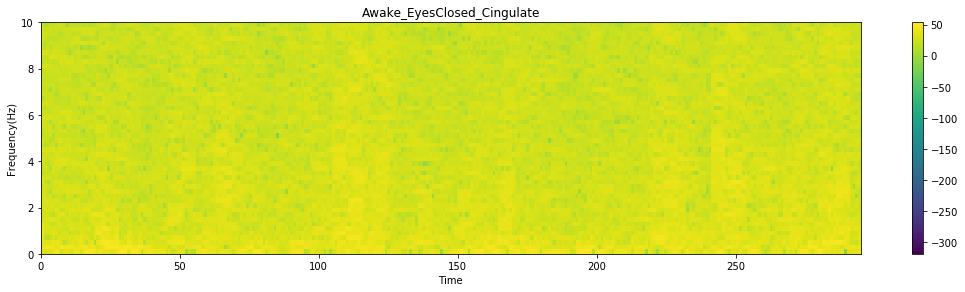

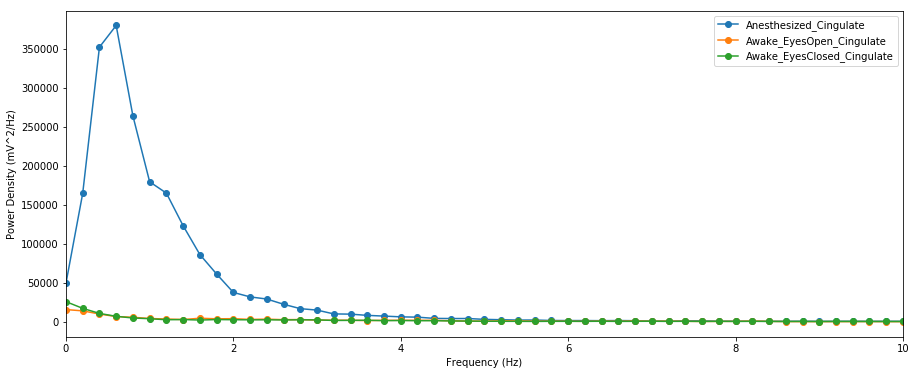

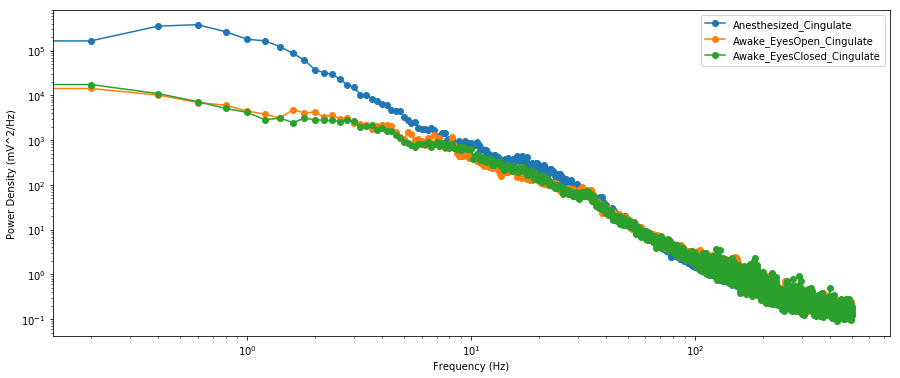

In [27]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Cingulate", stft_anes, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesOpen_Cingulate", stft_eo, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesClosed_Cingulate", stft_ec, freq_range=[0,10], plot_db=True)

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Cingulate", "Awake_EyesOpen_Cingulate", "Awake_EyesClosed_Cingulate"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Cingulate", "Awake_EyesOpen_Cingulate", "Awake_EyesClosed_Cingulate"], 
                    x_range = None, loglog=True)

## PS & PSD of Occipital Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

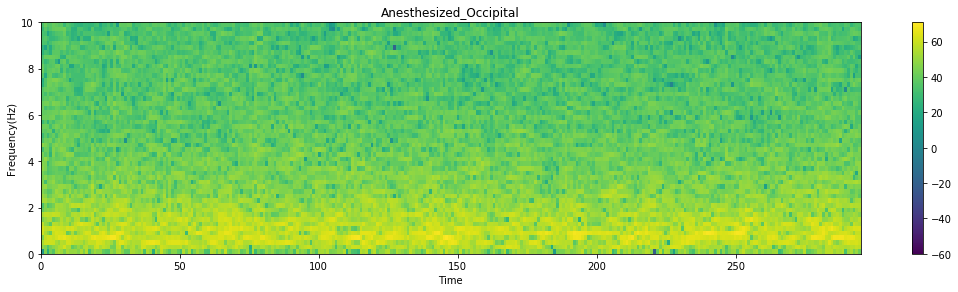

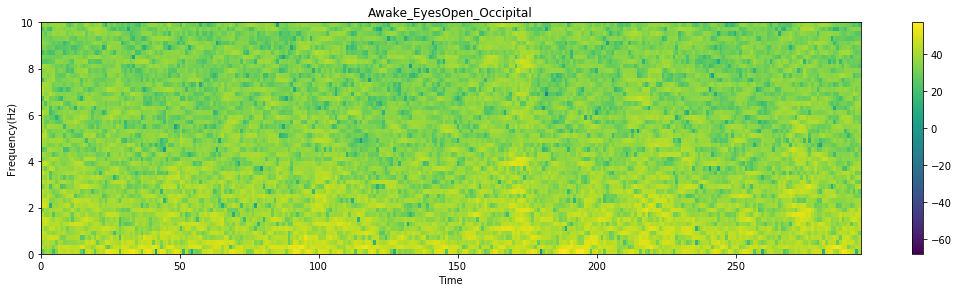

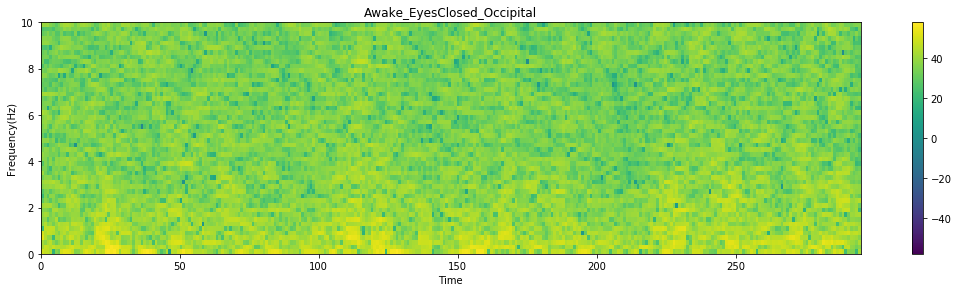

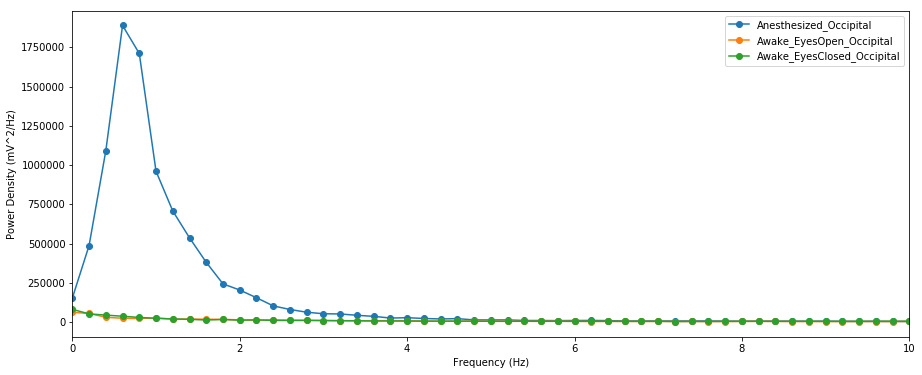

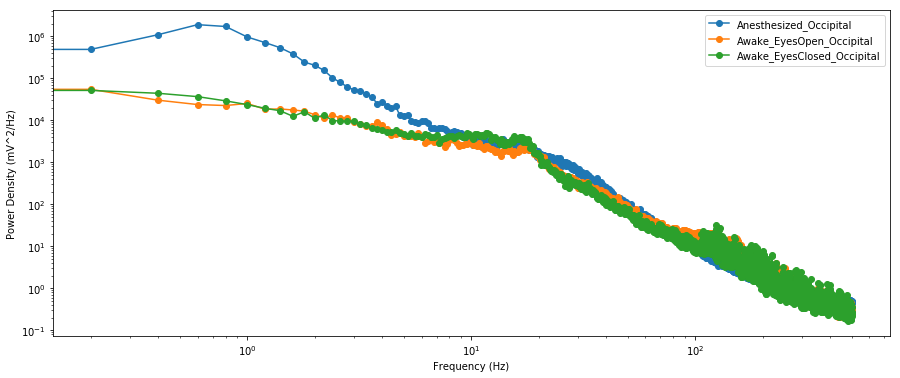

In [28]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'occipital'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Occipital", stft_anes, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesOpen_Occipital", stft_eo, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesClosed_Occipital", stft_ec, freq_range=[0,10], plot_db=True)

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Occipital", "Awake_EyesOpen_Occipital", "Awake_EyesClosed_Occipital"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Occipital", "Awake_EyesOpen_Occipital", "Awake_EyesClosed_Occipital"], 
                    x_range = None, loglog=True)

## PS & PSD of Temporal Cortex over Anesthetized, AwakeEyesOpen, AwakeEyesClosed

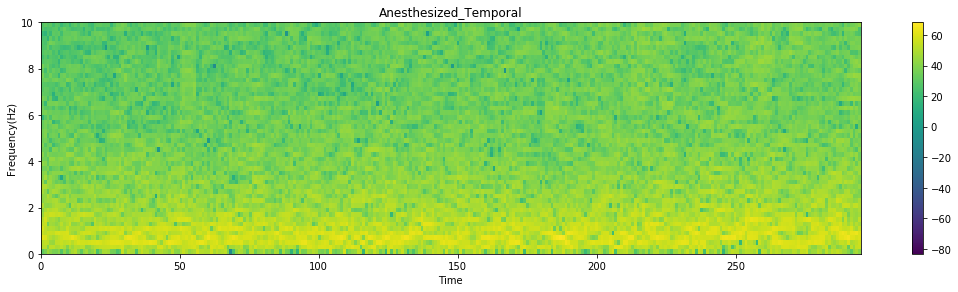

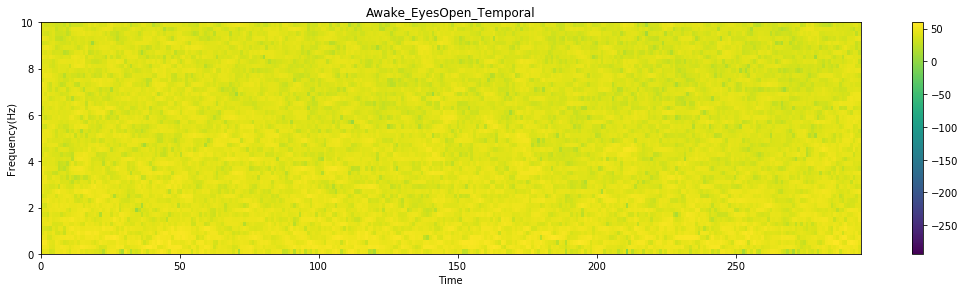

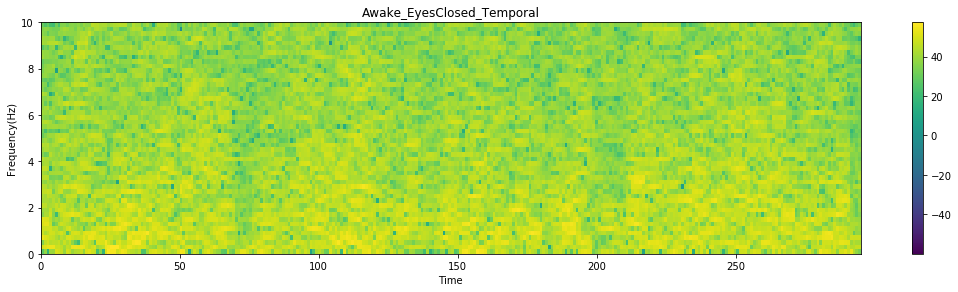

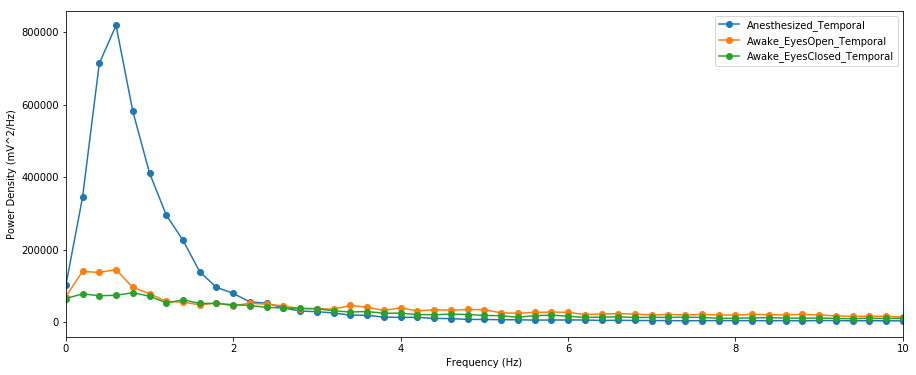

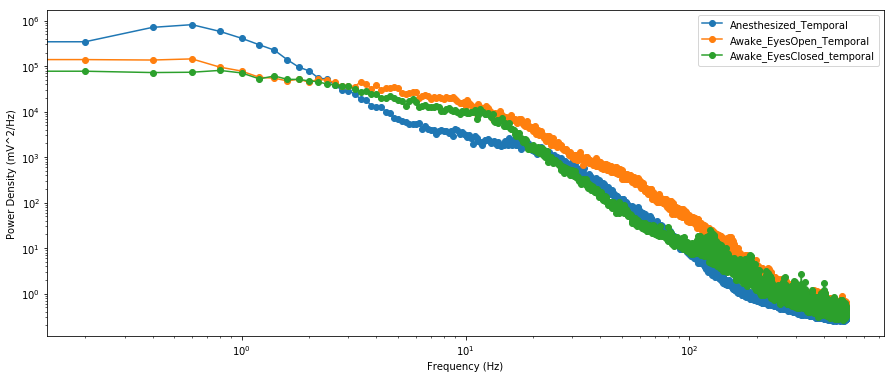

In [29]:
stft_anes = monkey.my_stft(monkey.signal(monkey.anes, 'temporal'), monkey.fs, len_win=5, len_overlap=4)
stft_eo = monkey.my_stft(monkey.signal(monkey.eyes_open, 'temporal'), monkey.fs, len_win=5, len_overlap=4)
stft_ec = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'temporal'), monkey.fs, len_win=5, len_overlap=4)

monkey.plot_spectrogram("Anesthesized_Temporal", stft_anes, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesOpen_Temporal", stft_eo, freq_range=[0,10], plot_db=True)
monkey.plot_spectrogram("Awake_EyesClosed_Temporal", stft_ec, freq_range=[0,10], plot_db=True)

monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Temporal", "Awake_EyesOpen_Temporal", "Awake_EyesClosed_Temporal"], 
                    x_range = [0,10])
monkey.plot_PSD_all(list([stft_anes, stft_eo, stft_ec]), 
                    labels = ["Anesthesized_Temporal", "Awake_EyesOpen_Temporal", "Awake_EyesClosed_temporal"], 
                    x_range = None, loglog=True)

## PSD comparison between Anethesized and Awake(Eyes Closed) states 

###  PSD displayed over various frequecy ranges 

### Slow Delta

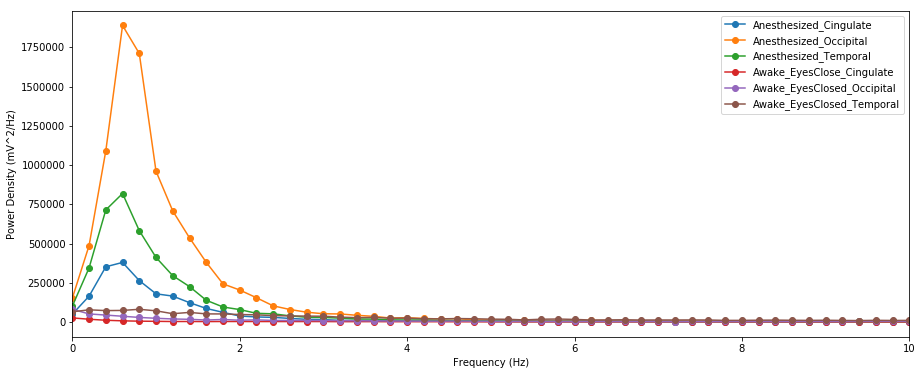

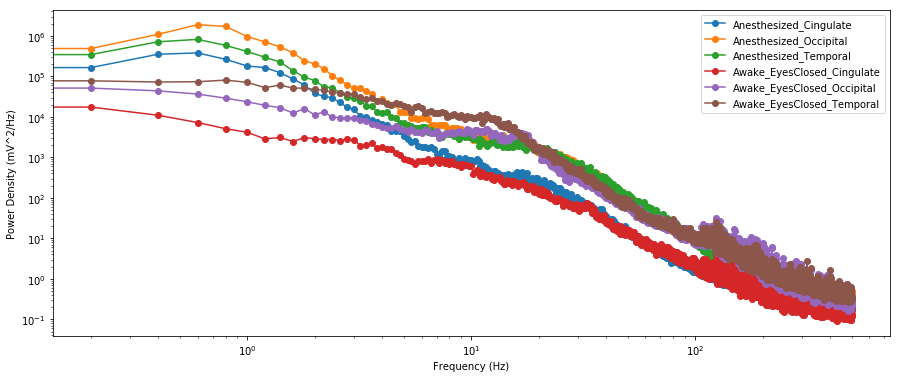

In [30]:
stft_anes_cing = monkey.my_stft(monkey.signal(monkey.anes, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_anes_occi = monkey.my_stft(monkey.signal(monkey.anes, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_anes_temp = monkey.my_stft(monkey.signal(monkey.anes, 'temporal'), monkey.fs, len_win=5, len_overlap=4)

stft_ec_cing = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'cingulate'), monkey.fs, len_win=5, len_overlap=4)
stft_ec_occi = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'occipital'), monkey.fs, len_win=5, len_overlap=4)
stft_ec_temp = monkey.my_stft(monkey.signal(monkey.eyes_closed, 'temporal'), monkey.fs, len_win=5, len_overlap=4)



monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_ec_cing, stft_ec_occi, stft_ec_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesClose_Cingulate", "Awake_EyesClosed_Occipital", "Awake_EyesClosed_Temporal"], 
                    x_range = [0,10])

monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_ec_cing, stft_ec_occi, stft_ec_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesClosed_Cingulate", "Awake_EyesClosed_Occipital", "Awake_EyesClosed_Temporal"], 
                    loglog = True)


### Gamma Range

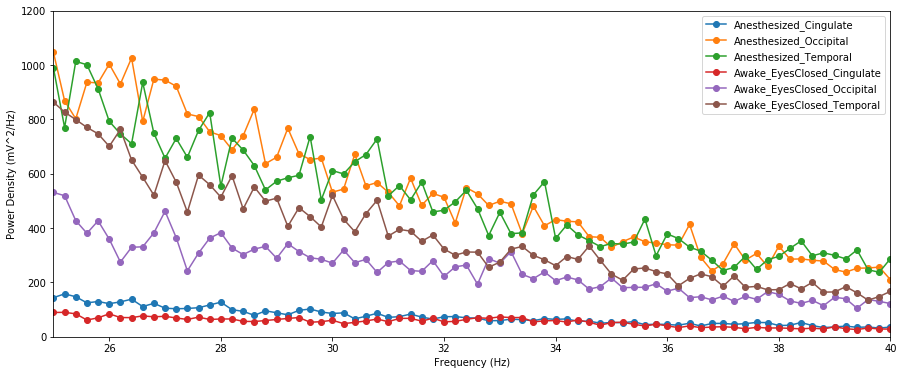

In [31]:
monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_ec_cing, stft_ec_occi, stft_ec_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesClosed_Cingulate", "Awake_EyesClosed_Occipital", "Awake_EyesClosed_Temporal"], 
                    x_range = [25,40], y_range = [0 ,1200])


### Theta

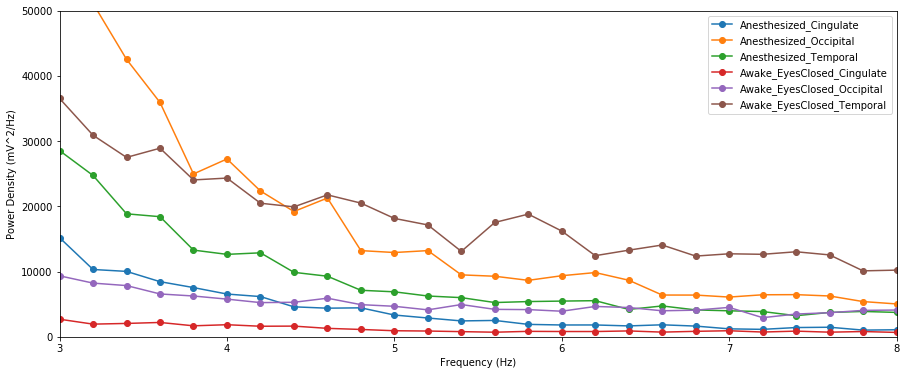

In [32]:
monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_ec_cing, stft_ec_occi, stft_ec_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesClosed_Cingulate", "Awake_EyesClosed_Occipital", "Awake_EyesClosed_Temporal"], 
                    x_range = [3,8], y_range = [0 ,50000])


### Alpha + Beta

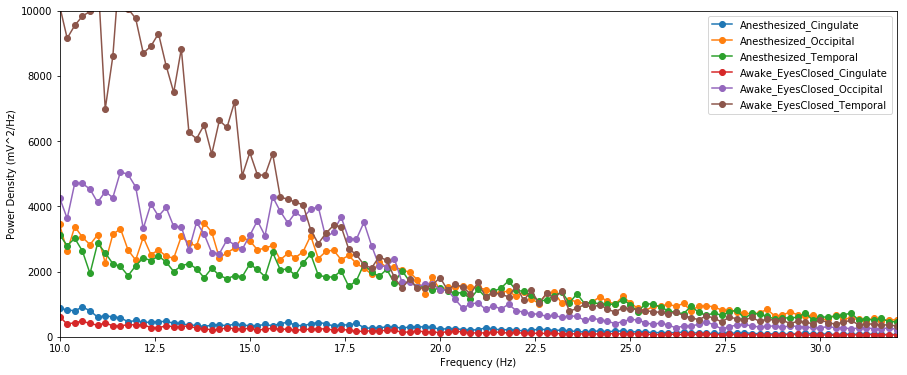

In [33]:
monkey.plot_PSD_all(list([stft_anes_cing, stft_anes_occi, stft_anes_temp, stft_ec_cing, stft_ec_occi, stft_ec_temp]), 
                    labels = ["Anesthesized_Cingulate", "Anesthesized_Occipital", "Anesthesized_Temporal", 
                              "Awake_EyesClosed_Cingulate", "Awake_EyesClosed_Occipital", "Awake_EyesClosed_Temporal"], 
                    x_range = [10,32], y_range = [0 ,10000])


# Filter & Hilbert

# Delta Band (0.1-4Hz)

### Filter

Text(0.5,1,'Signal Filtered at 0.1-4Hz Delta')

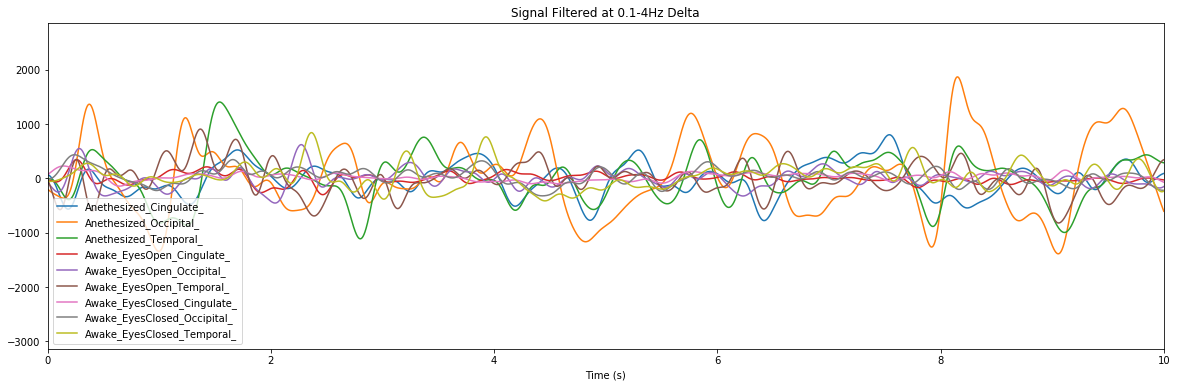

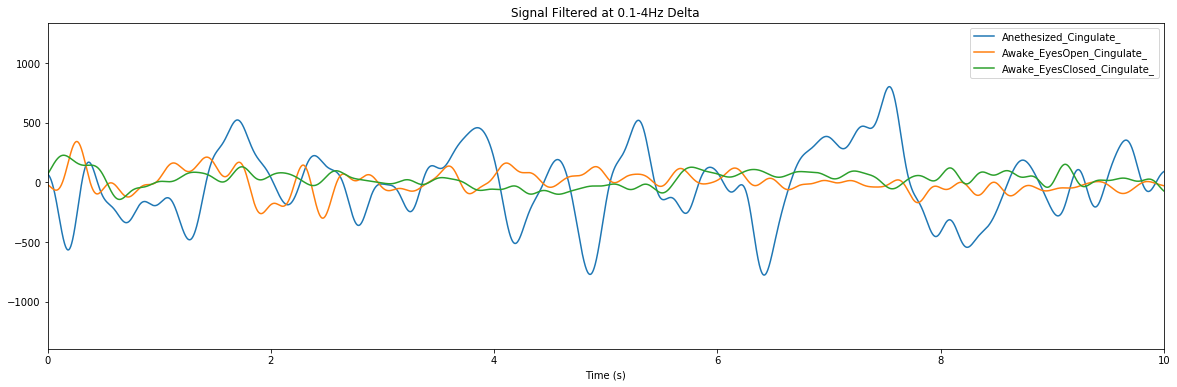

In [38]:
band = [0.1,4]
fir_anes_cin = monkey.band_pass_filter(monkey.signal(monkey.anes, 'cingulate'), band)
fir_anes_occ = monkey.band_pass_filter(monkey.signal(monkey.anes, 'occipital'), band)
fir_anes_tem = monkey.band_pass_filter(monkey.signal(monkey.anes, 'temporal'), band)

fir_eo_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'cingulate'), band)
fir_eo_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'occipital'), band)
fir_eo_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'temporal'), band)

fir_ec_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'cingulate'), band)
fir_ec_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'occipital'), band)
fir_ec_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'temporal'), band)


signals = list([fir_anes_cin, fir_anes_occ, fir_anes_tem,
                          fir_eo_cin, fir_eo_occ, fir_eo_tem,
                          fir_ec_cin, fir_ec_occ, fir_ec_tem])
labels = ['Anethesized_Cingulate_', 'Anethesized_Occipital_', 'Anethesized_Temporal_',
                     'Awake_EyesOpen_Cingulate_', 'Awake_EyesOpen_Occipital_', 'Awake_EyesOpen_Temporal_',
                     'Awake_EyesClosed_Cingulate_', 'Awake_EyesClosed_Occipital_', 'Awake_EyesClosed_Temporal_']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 0.1-4Hz Delta")


signals = list([fir_anes_cin, fir_eo_cin, fir_ec_cin])
labels = ['Anethesized_Cingulate_', 'Awake_EyesOpen_Cingulate_', 'Awake_EyesClosed_Cingulate_']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 0.1-4Hz Delta")



### Analytic Power over Time

Text(0.5,1,'Averge of Power Means')

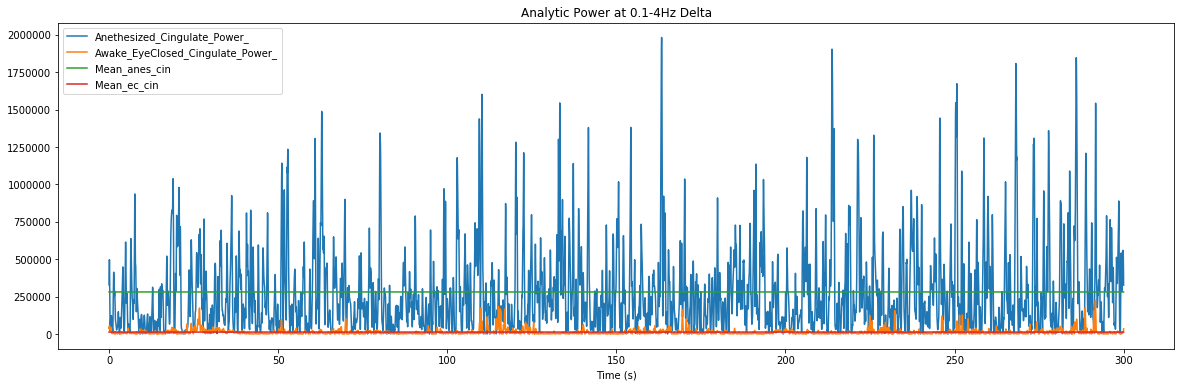

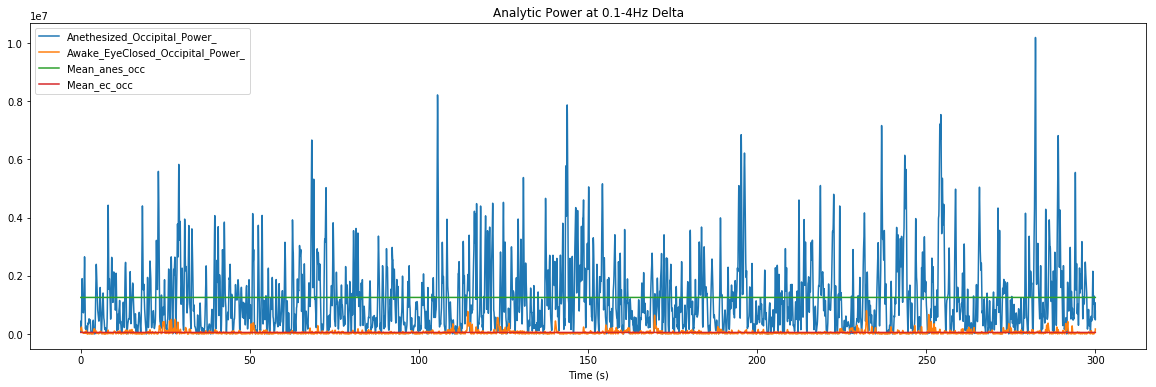

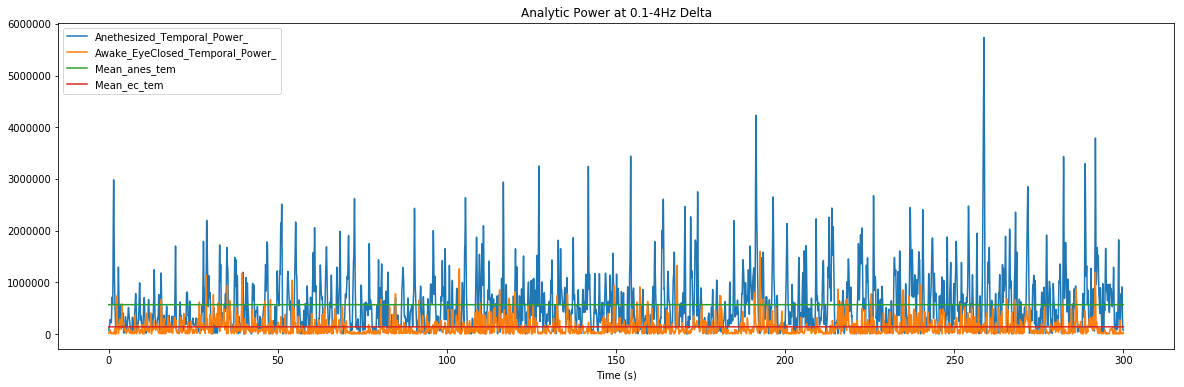

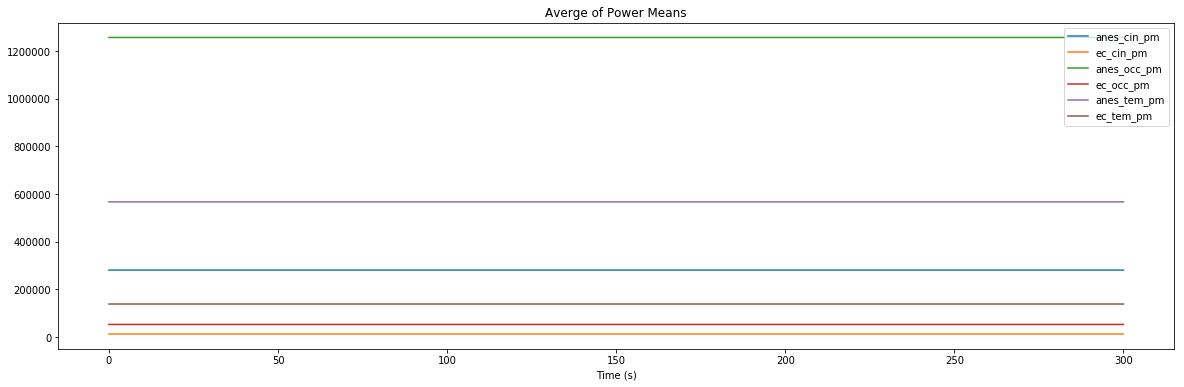

In [39]:
# Power over time (Hilbert)

anes_cin_analytic = signal.hilbert(fir_anes_cin)
anes_cin_power, anes_cin_phase = ECoG_data.compute_power_phase(anes_cin_analytic)
ec_cin_analytic = signal.hilbert(fir_ec_cin)
ec_cin_power, ec_cin_phase = ECoG_data.compute_power_phase(ec_cin_analytic)

anes_occ_analytic = signal.hilbert(fir_anes_occ)
anes_occ_power, anes_occ_phase = ECoG_data.compute_power_phase(anes_occ_analytic)
ec_occ_analytic = signal.hilbert(fir_ec_occ)
ec_occ_power, ec_occ_phase = ECoG_data.compute_power_phase(ec_occ_analytic)

anes_tem_analytic = signal.hilbert(fir_anes_tem)
anes_tem_power, anes_tem_phase = ECoG_data.compute_power_phase(anes_tem_analytic)
ec_tem_analytic = signal.hilbert(fir_ec_tem)
ec_tem_power, ec_tem_phase = ECoG_data.compute_power_phase(ec_tem_analytic)



anes_cin_pm = np.repeat(anes_cin_power.mean(), len(anes_cin_power))
ec_cin_pm = np.repeat(ec_cin_power.mean(), len(ec_cin_power))
sigs = list([anes_cin_power, ec_cin_power, anes_cin_pm, ec_cin_pm]) 
labels = ['Anethesized_Cingulate_Power_', 'Awake_EyeClosed_Cingulate_Power_', 'Mean_anes_cin', 'Mean_ec_cin']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 0.1-4Hz Delta")


anes_occ_pm = np.repeat(anes_occ_power.mean(), len(anes_occ_power))
ec_occ_pm = np.repeat(ec_occ_power.mean(), len(ec_occ_power))
sigs = list([anes_occ_power, ec_occ_power, anes_occ_pm, ec_occ_pm])
labels = ['Anethesized_Occipital_Power_', 'Awake_EyeClosed_Occipital_Power_', 'Mean_anes_occ', 'Mean_ec_occ']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 0.1-4Hz Delta")


anes_tem_pm = np.repeat(anes_tem_power.mean(), len(anes_tem_power))
ec_tem_pm = np.repeat(ec_tem_power.mean(), len(ec_tem_power))
sigs = list([anes_tem_power, ec_tem_power, anes_tem_pm, ec_tem_pm])
labels = ['Anethesized_Temporal_Power_', 'Awake_EyeClosed_Temporal_Power_', 'Mean_anes_tem', 'Mean_ec_tem']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 0.1-4Hz Delta")



monkey.plot_signals(list([anes_cin_pm, ec_cin_pm, anes_occ_pm, ec_occ_pm, anes_tem_pm, ec_tem_pm]), 
                    labels = ['anes_cin_pm', 'ec_cin_pm', 'anes_occ_pm', 'ec_occ_pm', 'anes_tem_pm', 'ec_tem_pm'])
plt.title("Averge of Power Means")


### Frequency over time (derivative of phase)

Text(0,0.5,'Frequency')

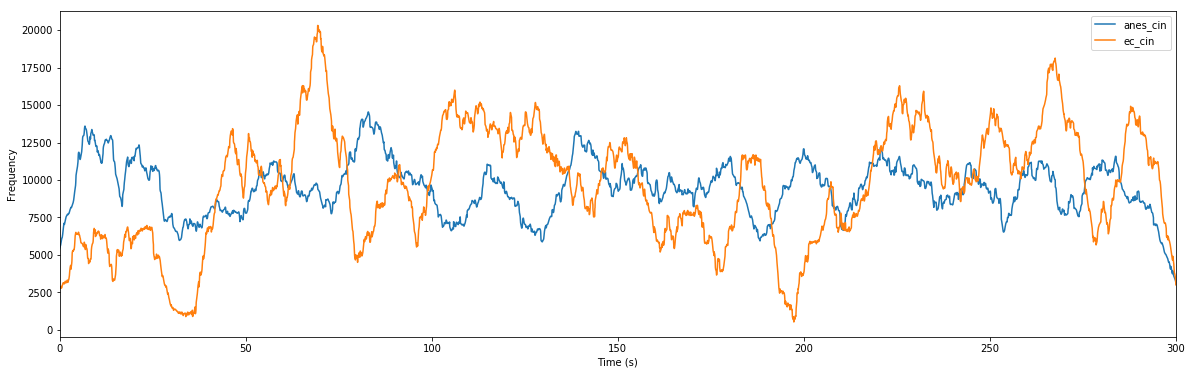

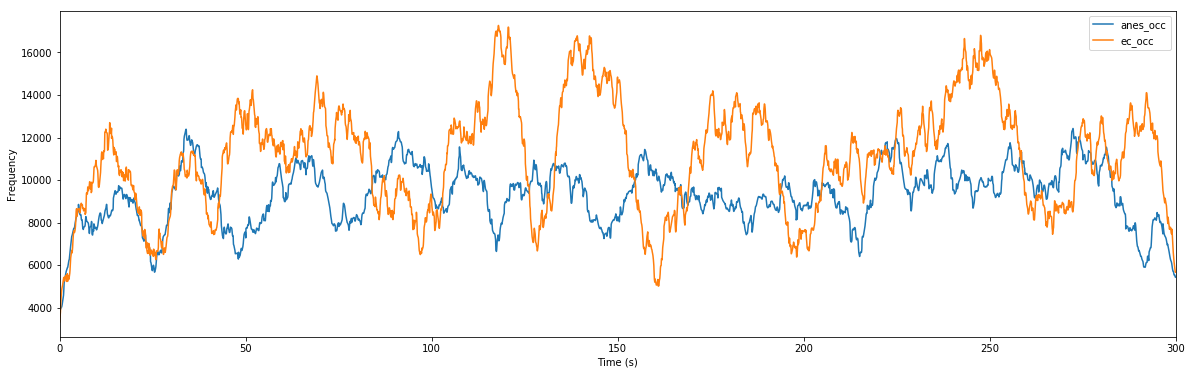

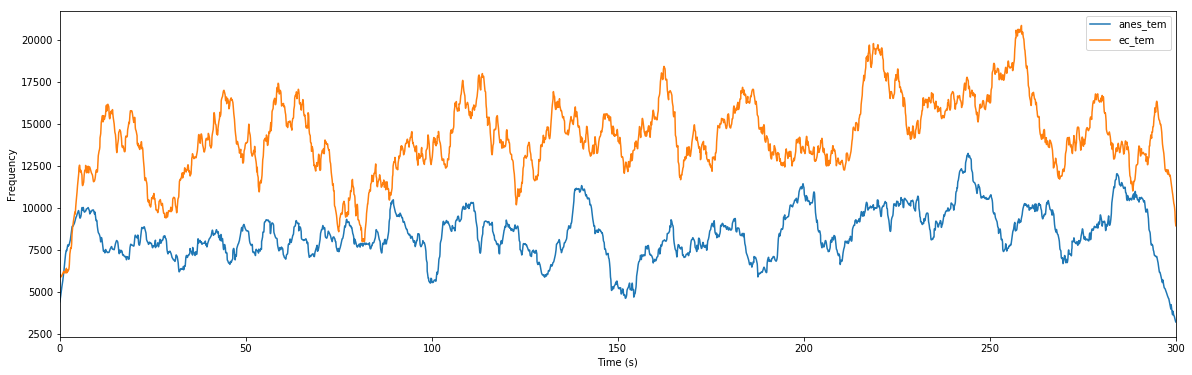

In [32]:
inst_freqs_anes_cin = np.append(np.diff(np.unwrap(anes_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_occ = np.append(np.diff(np.unwrap(anes_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_tem = np.append(np.diff(np.unwrap(anes_tem_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_cin = np.append(np.diff(np.unwrap(ec_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_occ = np.append(np.diff(np.unwrap(ec_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_tem = np.append(np.diff(np.unwrap(ec_tem_phase) / (2.0 * np.pi) * monkey.fs),0)



sigs = [inst_freqs_anes_cin, inst_freqs_ec_cin]
labels = ['anes_cin','ec_cin']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_occ, inst_freqs_ec_occ]
labels = ['anes_occ','ec_occ']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_tem, inst_freqs_ec_tem]
labels = ['anes_tem','ec_tem']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


# Gamma Band (25-40)

### Filter

Text(0.5,1,'Signal Filtered at 25-40Hz Gamma')

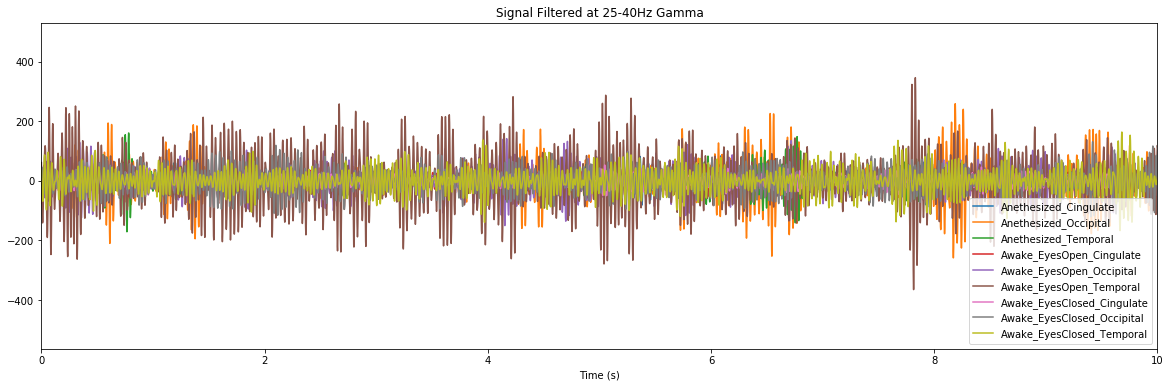

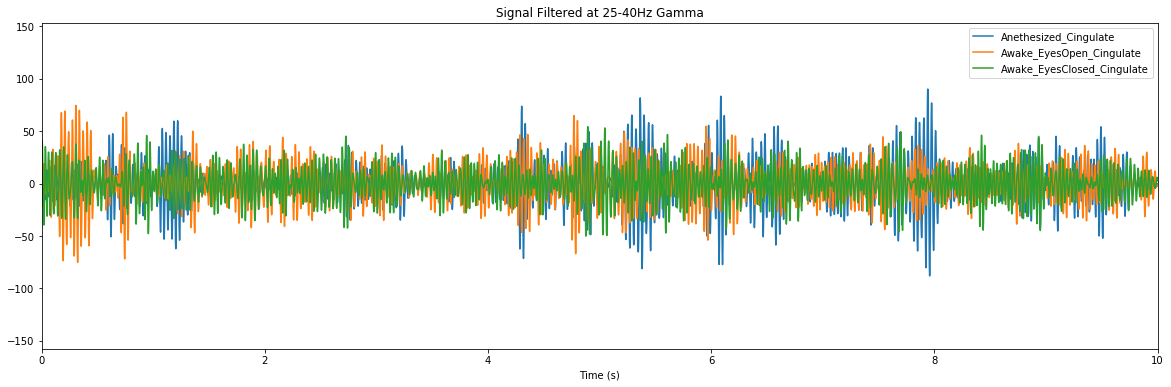

In [40]:
band = [25,40]
fir_anes_cin = monkey.band_pass_filter(monkey.signal(monkey.anes, 'cingulate'), band)
fir_anes_occ = monkey.band_pass_filter(monkey.signal(monkey.anes, 'occipital'), band)
fir_anes_tem = monkey.band_pass_filter(monkey.signal(monkey.anes, 'temporal'), band)

fir_eo_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'cingulate'), band)
fir_eo_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'occipital'), band)
fir_eo_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'temporal'), band)

fir_ec_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'cingulate'), band)
fir_ec_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'occipital'), band)
fir_ec_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'temporal'), band)


signals = list([fir_anes_cin, fir_anes_occ, fir_anes_tem,
                          fir_eo_cin, fir_eo_occ, fir_eo_tem,
                          fir_ec_cin, fir_ec_occ, fir_ec_tem])
labels = ['Anethesized_Cingulate', 'Anethesized_Occipital', 'Anethesized_Temporal',
                     'Awake_EyesOpen_Cingulate', 'Awake_EyesOpen_Occipital', 'Awake_EyesOpen_Temporal',
                     'Awake_EyesClosed_Cingulate', 'Awake_EyesClosed_Occipital', 'Awake_EyesClosed_Temporal']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 25-40Hz Gamma")



signals = list([fir_anes_cin, fir_eo_cin, fir_ec_cin])
labels = ['Anethesized_Cingulate', 'Awake_EyesOpen_Cingulate', 'Awake_EyesClosed_Cingulate']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 25-40Hz Gamma")





### Analytic Power over Time

Text(0.5,1,'Averge of Power Means')

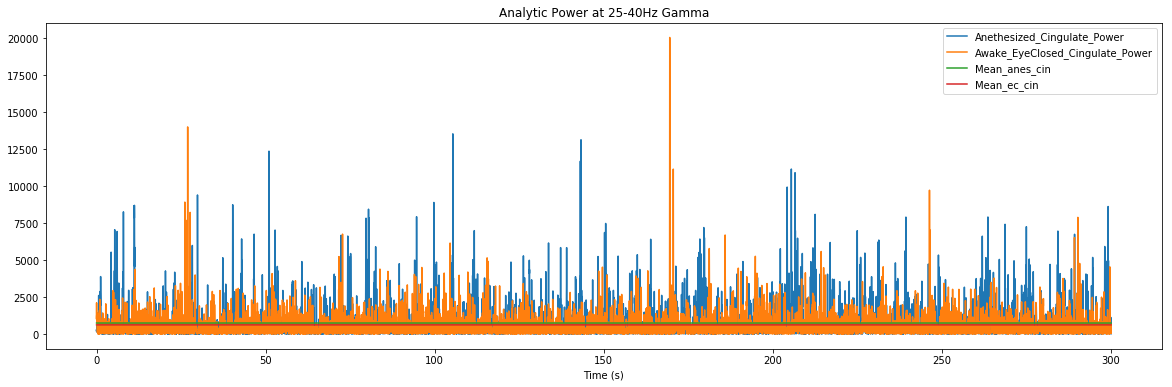

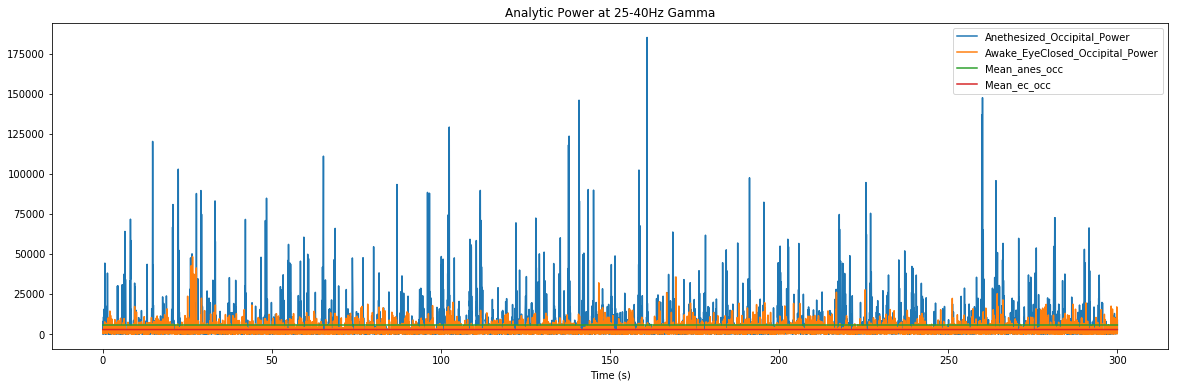

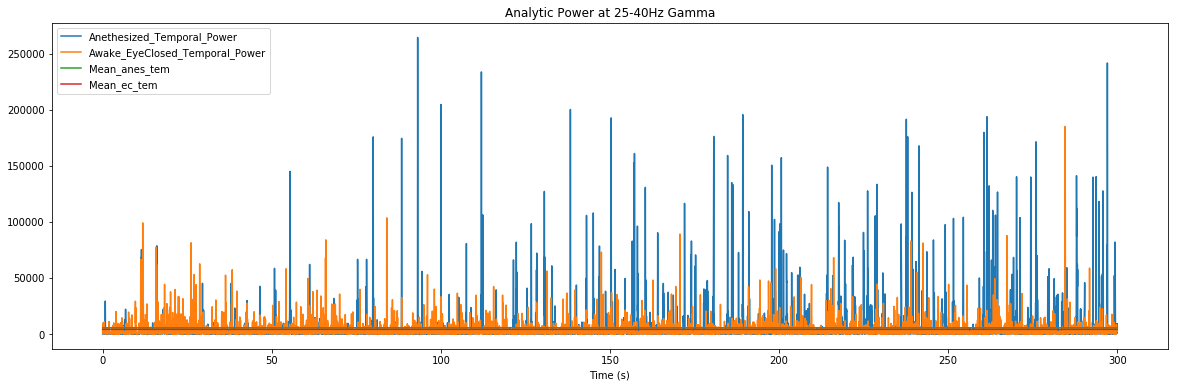

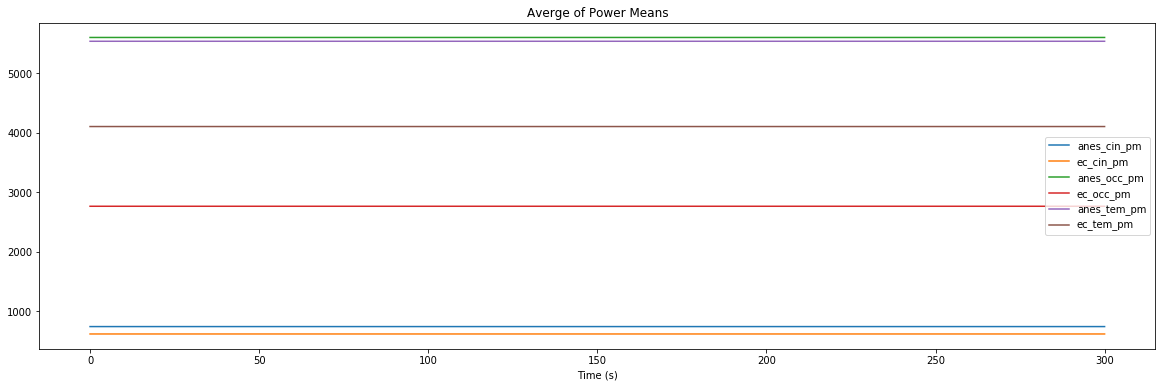

In [41]:
# Power over time (Hilbert)

anes_cin_analytic = signal.hilbert(fir_anes_cin)
anes_cin_power, anes_cin_phase = ECoG_data.compute_power_phase(anes_cin_analytic)
ec_cin_analytic = signal.hilbert(fir_ec_cin)
ec_cin_power, ec_cin_phase = ECoG_data.compute_power_phase(ec_cin_analytic)

anes_occ_analytic = signal.hilbert(fir_anes_occ)
anes_occ_power, anes_occ_phase = ECoG_data.compute_power_phase(anes_occ_analytic)
ec_occ_analytic = signal.hilbert(fir_ec_occ)
ec_occ_power, ec_occ_phase = ECoG_data.compute_power_phase(ec_occ_analytic)

anes_tem_analytic = signal.hilbert(fir_anes_tem)
anes_tem_power, anes_tem_phase = ECoG_data.compute_power_phase(anes_tem_analytic)
ec_tem_analytic = signal.hilbert(fir_ec_tem)
ec_tem_power, ec_tem_phase = ECoG_data.compute_power_phase(ec_tem_analytic)


#monkey.plot_signal("Anethesized_Cingulate_Power", power)#, x_range=[0,10], y_range=[0,300000])

anes_cin_pm = np.repeat(anes_cin_power.mean(), len(anes_cin_power))
ec_cin_pm = np.repeat(ec_cin_power.mean(), len(ec_cin_power))
sigs = list([anes_cin_power, ec_cin_power, anes_cin_pm, ec_cin_pm]) 
labels = ['Anethesized_Cingulate_Power', 'Awake_EyeClosed_Cingulate_Power', 'Mean_anes_cin', 'Mean_ec_cin']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 25-40Hz Gamma")




anes_occ_pm = np.repeat(anes_occ_power.mean(), len(anes_occ_power))
ec_occ_pm = np.repeat(ec_occ_power.mean(), len(ec_occ_power))
sigs = list([anes_occ_power, ec_occ_power, anes_occ_pm, ec_occ_pm])
labels = ['Anethesized_Occipital_Power', 'Awake_EyeClosed_Occipital_Power', 'Mean_anes_occ', 'Mean_ec_occ']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 25-40Hz Gamma")


anes_tem_pm = np.repeat(anes_tem_power.mean(), len(anes_tem_power))
ec_tem_pm = np.repeat(ec_tem_power.mean(), len(ec_tem_power))
sigs = list([anes_tem_power, ec_tem_power, anes_tem_pm, ec_tem_pm])
labels = ['Anethesized_Temporal_Power', 'Awake_EyeClosed_Temporal_Power', 'Mean_anes_tem', 'Mean_ec_tem']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 25-40Hz Gamma")



monkey.plot_signals(list([anes_cin_pm, ec_cin_pm, anes_occ_pm, ec_occ_pm, anes_tem_pm, ec_tem_pm]), 
                    labels = ['anes_cin_pm', 'ec_cin_pm', 'anes_occ_pm', 'ec_occ_pm', 'anes_tem_pm', 'ec_tem_pm'])
plt.title("Averge of Power Means")

### Frequency over time (derivative of phase)

Text(0,0.5,'Frequency')

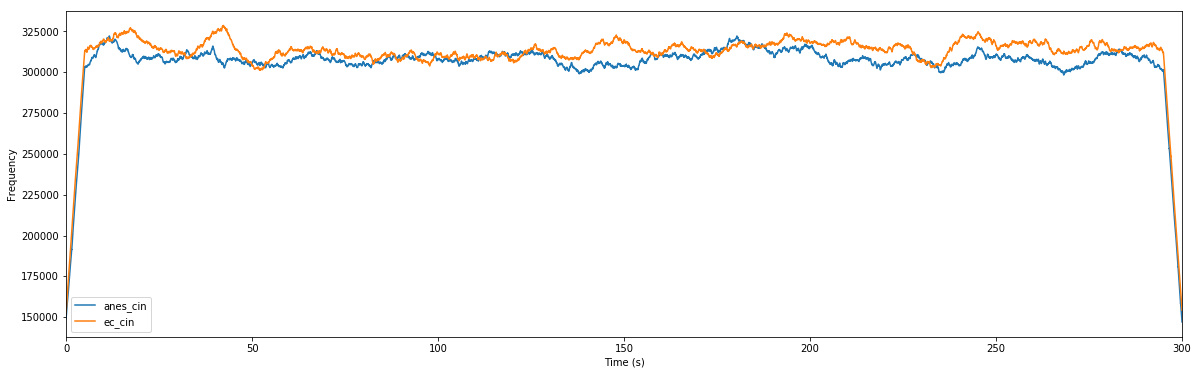

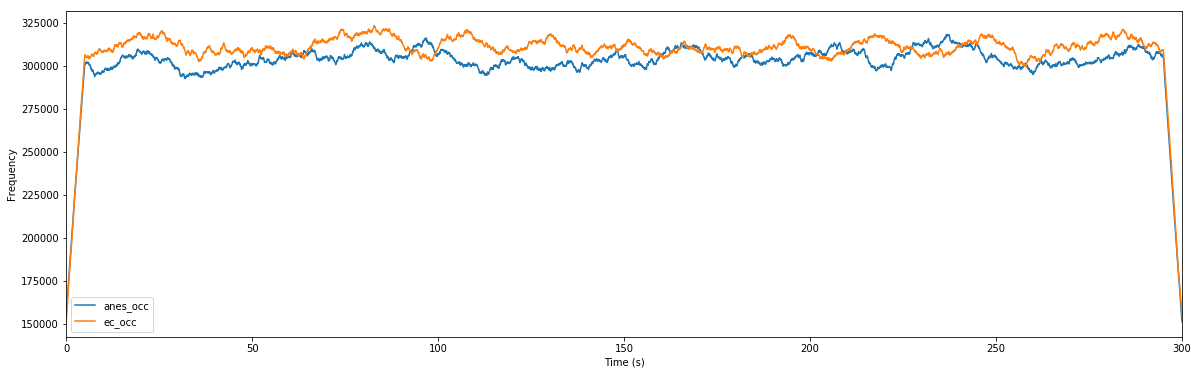

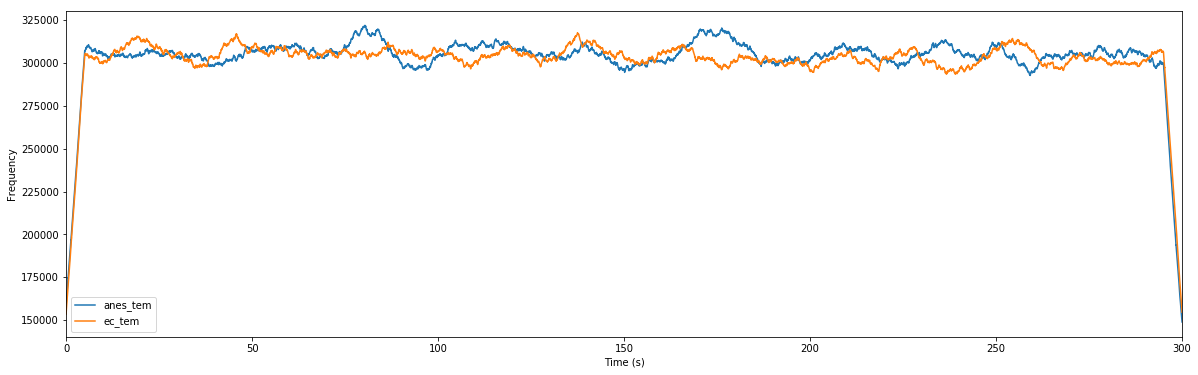

In [35]:
inst_freqs_anes_cin = np.append(np.diff(np.unwrap(anes_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_occ = np.append(np.diff(np.unwrap(anes_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_tem = np.append(np.diff(np.unwrap(anes_tem_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_cin = np.append(np.diff(np.unwrap(ec_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_occ = np.append(np.diff(np.unwrap(ec_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_tem = np.append(np.diff(np.unwrap(ec_tem_phase) / (2.0 * np.pi) * monkey.fs),0)



sigs = [inst_freqs_anes_cin, inst_freqs_ec_cin]
labels = ['anes_cin','ec_cin']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_occ, inst_freqs_ec_occ]
labels = ['anes_occ','ec_occ']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_tem, inst_freqs_ec_tem]
labels = ['anes_tem','ec_tem']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


# Theta (3-8Hz)

### Filter

Text(0.5,1,'Signal Filtered at 3-8Hz Theta')

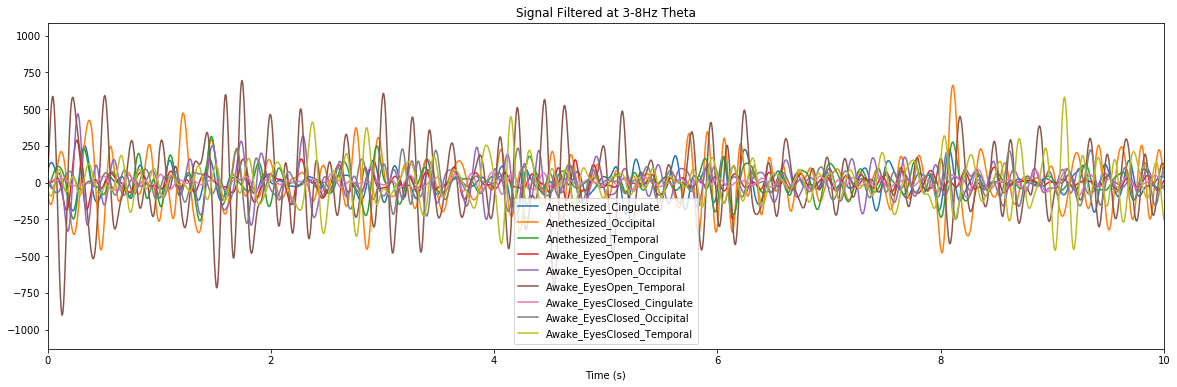

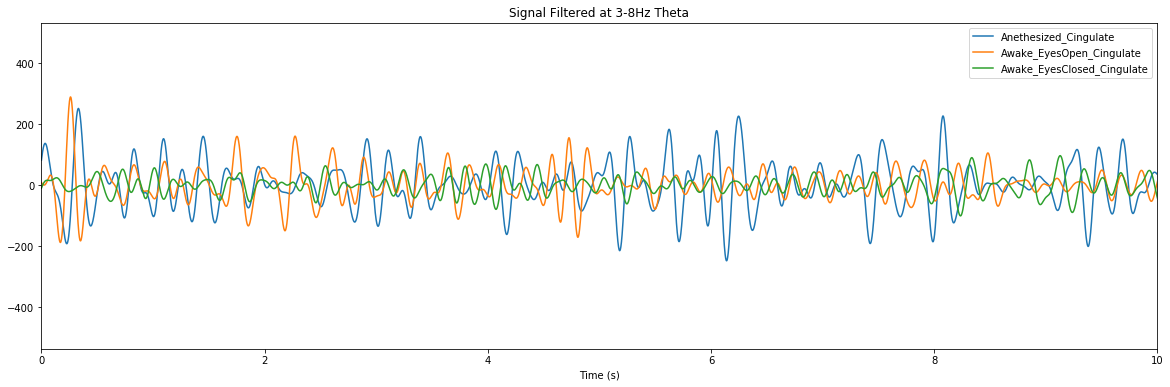

In [42]:
band = [3,8]
fir_anes_cin = monkey.band_pass_filter(monkey.signal(monkey.anes, 'cingulate'), band)
fir_anes_occ = monkey.band_pass_filter(monkey.signal(monkey.anes, 'occipital'), band)
fir_anes_tem = monkey.band_pass_filter(monkey.signal(monkey.anes, 'temporal'), band)

fir_eo_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'cingulate'), band)
fir_eo_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'occipital'), band)
fir_eo_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'temporal'), band)

fir_ec_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'cingulate'), band)
fir_ec_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'occipital'), band)
fir_ec_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'temporal'), band)


signals = list([fir_anes_cin, fir_anes_occ, fir_anes_tem,
                          fir_eo_cin, fir_eo_occ, fir_eo_tem,
                          fir_ec_cin, fir_ec_occ, fir_ec_tem])
labels = ['Anethesized_Cingulate', 'Anethesized_Occipital', 'Anethesized_Temporal',
                     'Awake_EyesOpen_Cingulate', 'Awake_EyesOpen_Occipital', 'Awake_EyesOpen_Temporal',
                     'Awake_EyesClosed_Cingulate', 'Awake_EyesClosed_Occipital', 'Awake_EyesClosed_Temporal']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 3-8Hz Theta")


signals = list([fir_anes_cin, fir_eo_cin, fir_ec_cin])
labels = ['Anethesized_Cingulate', 'Awake_EyesOpen_Cingulate', 'Awake_EyesClosed_Cingulate']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 3-8Hz Theta")





### Analytic Power over Time

Text(0.5,1,'Averge of Power Means')

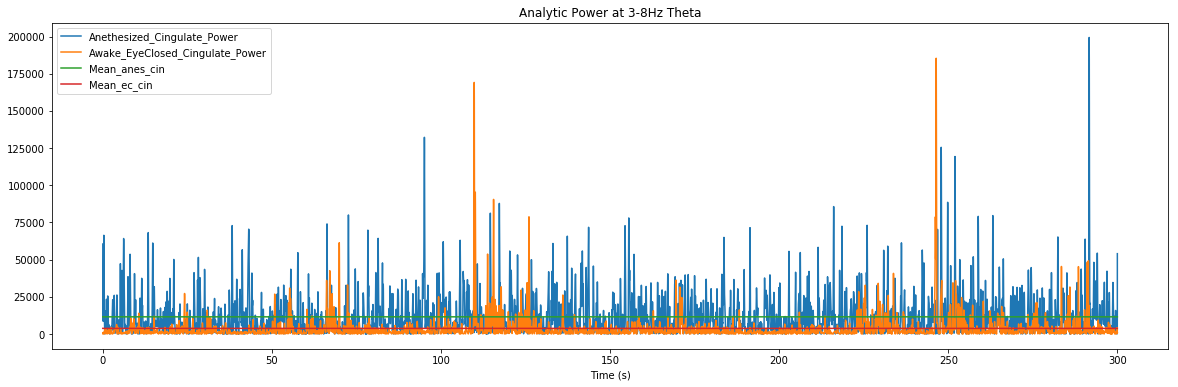

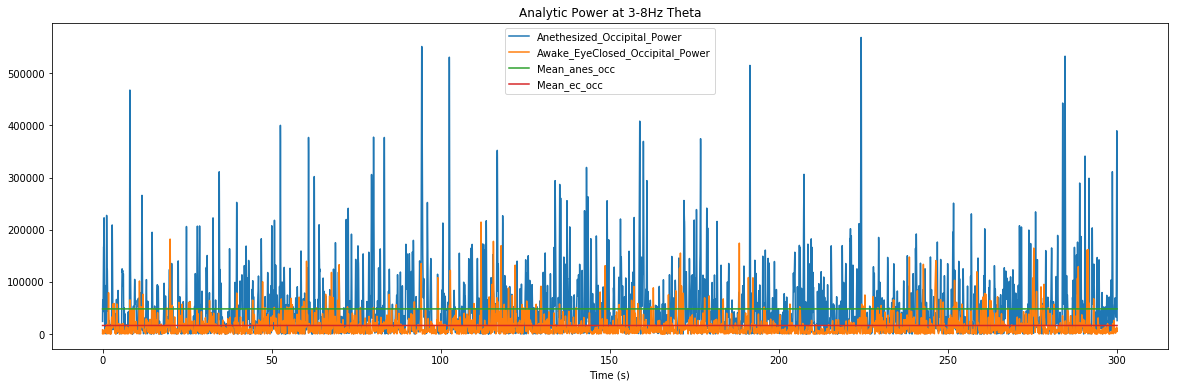

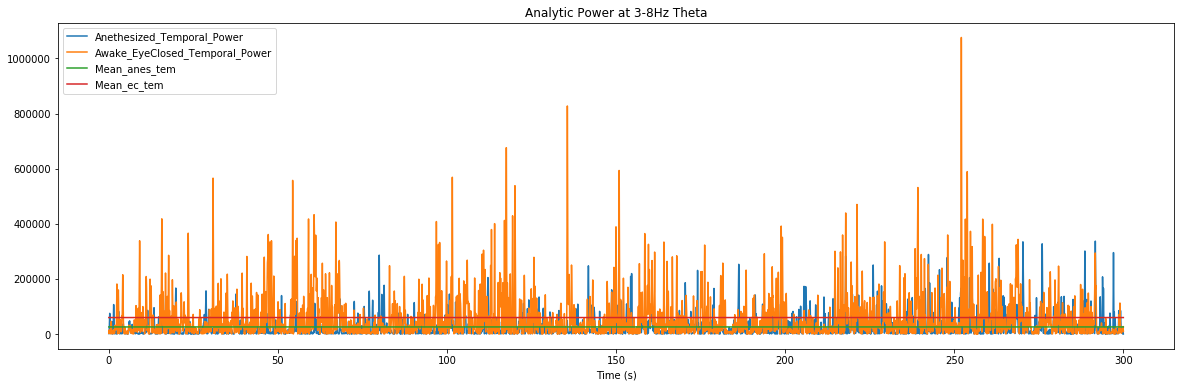

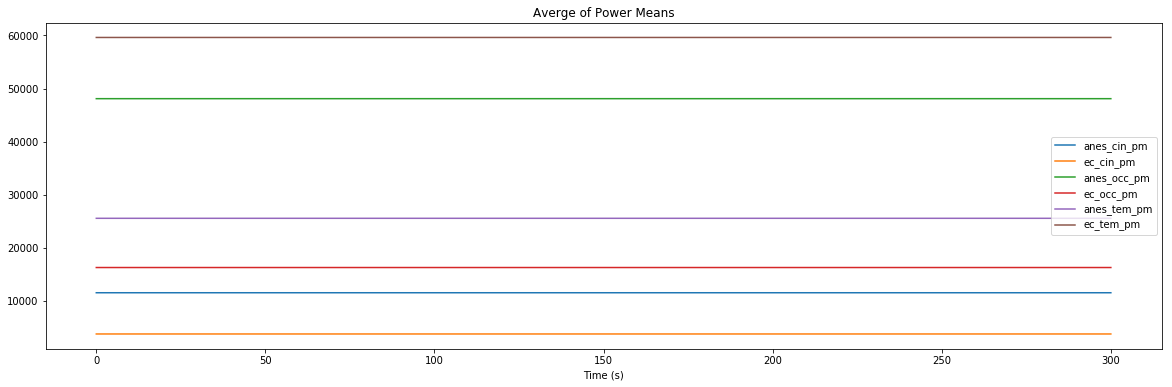

In [43]:
# Power over time (Hilbert)

anes_cin_analytic = signal.hilbert(fir_anes_cin)
anes_cin_power, anes_cin_phase = ECoG_data.compute_power_phase(anes_cin_analytic)
ec_cin_analytic = signal.hilbert(fir_ec_cin)
ec_cin_power, ec_cin_phase = ECoG_data.compute_power_phase(ec_cin_analytic)

anes_occ_analytic = signal.hilbert(fir_anes_occ)
anes_occ_power, anes_occ_phase = ECoG_data.compute_power_phase(anes_occ_analytic)
ec_occ_analytic = signal.hilbert(fir_ec_occ)
ec_occ_power, ec_occ_phase = ECoG_data.compute_power_phase(ec_occ_analytic)

anes_tem_analytic = signal.hilbert(fir_anes_tem)
anes_tem_power, anes_tem_phase = ECoG_data.compute_power_phase(anes_tem_analytic)
ec_tem_analytic = signal.hilbert(fir_ec_tem)
ec_tem_power, ec_tem_phase = ECoG_data.compute_power_phase(ec_tem_analytic)


#monkey.plot_signal("Anethesized_Cingulate_Power", power)#, x_range=[0,10], y_range=[0,300000])

anes_cin_pm = np.repeat(anes_cin_power.mean(), len(anes_cin_power))
ec_cin_pm = np.repeat(ec_cin_power.mean(), len(ec_cin_power))
sigs = list([anes_cin_power, ec_cin_power, anes_cin_pm, ec_cin_pm]) 
labels = ['Anethesized_Cingulate_Power', 'Awake_EyeClosed_Cingulate_Power', 'Mean_anes_cin', 'Mean_ec_cin']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 3-8Hz Theta")




anes_occ_pm = np.repeat(anes_occ_power.mean(), len(anes_occ_power))
ec_occ_pm = np.repeat(ec_occ_power.mean(), len(ec_occ_power))
sigs = list([anes_occ_power, ec_occ_power, anes_occ_pm, ec_occ_pm])
labels = ['Anethesized_Occipital_Power', 'Awake_EyeClosed_Occipital_Power', 'Mean_anes_occ', 'Mean_ec_occ']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 3-8Hz Theta")



anes_tem_pm = np.repeat(anes_tem_power.mean(), len(anes_tem_power))
ec_tem_pm = np.repeat(ec_tem_power.mean(), len(ec_tem_power))
sigs = list([anes_tem_power, ec_tem_power, anes_tem_pm, ec_tem_pm])
labels = ['Anethesized_Temporal_Power', 'Awake_EyeClosed_Temporal_Power', 'Mean_anes_tem', 'Mean_ec_tem']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 3-8Hz Theta")




monkey.plot_signals(list([anes_cin_pm, ec_cin_pm, anes_occ_pm, ec_occ_pm, anes_tem_pm, ec_tem_pm]), 
                    labels = ['anes_cin_pm', 'ec_cin_pm', 'anes_occ_pm', 'ec_occ_pm', 'anes_tem_pm', 'ec_tem_pm'])
plt.title("Averge of Power Means")

### Frequency over time (derivative of phase)

Text(0,0.5,'Frequency')

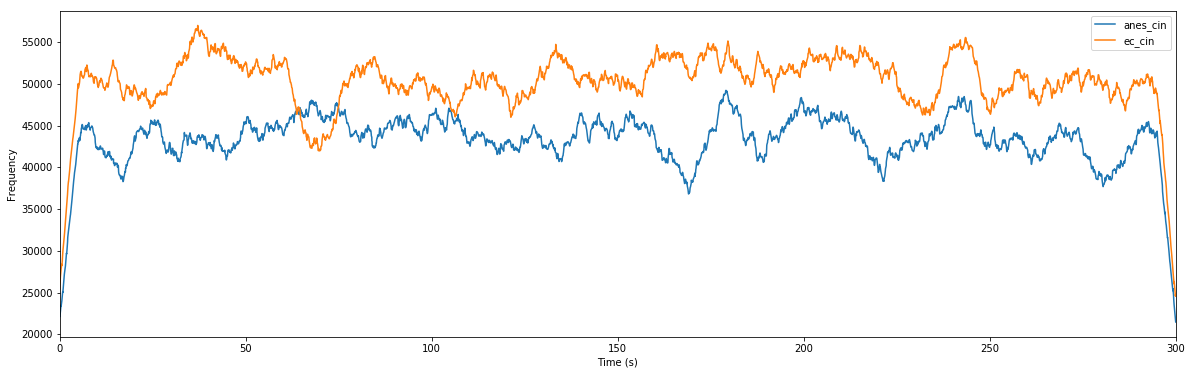

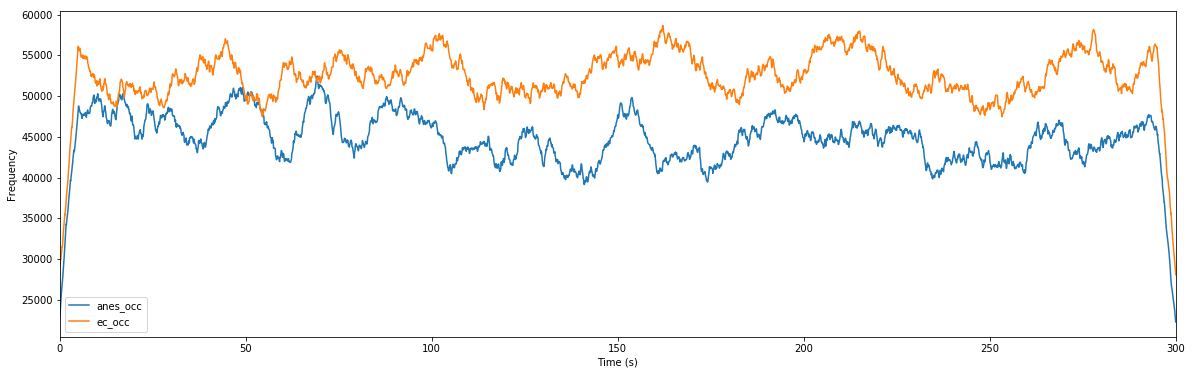

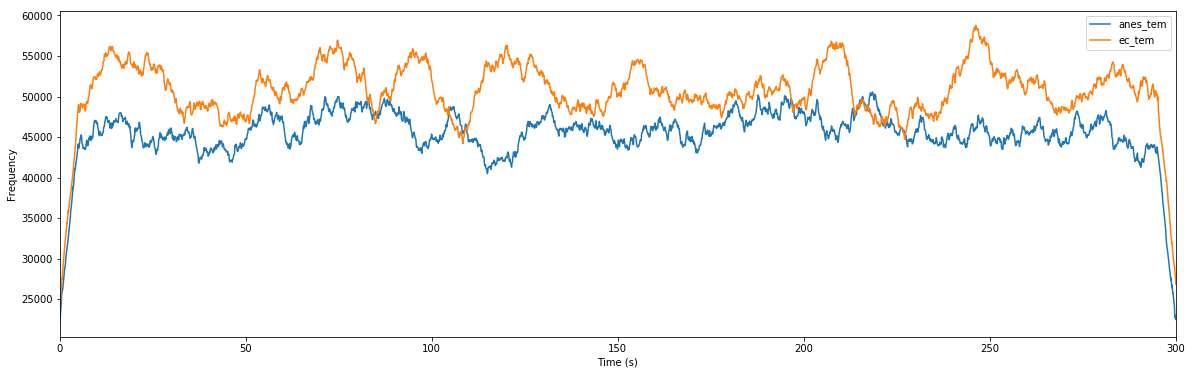

In [38]:
inst_freqs_anes_cin = np.append(np.diff(np.unwrap(anes_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_occ = np.append(np.diff(np.unwrap(anes_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_tem = np.append(np.diff(np.unwrap(anes_tem_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_cin = np.append(np.diff(np.unwrap(ec_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_occ = np.append(np.diff(np.unwrap(ec_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_tem = np.append(np.diff(np.unwrap(ec_tem_phase) / (2.0 * np.pi) * monkey.fs),0)



sigs = [inst_freqs_anes_cin, inst_freqs_ec_cin]
labels = ['anes_cin','ec_cin']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_occ, inst_freqs_ec_occ]
labels = ['anes_occ','ec_occ']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_tem, inst_freqs_ec_tem]
labels = ['anes_tem','ec_tem']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


# Alpha + Beta (10-32Hz)

### Filter

Text(0.5,1,'Signal Filtered at 10-32Hz Alpha+Beta')

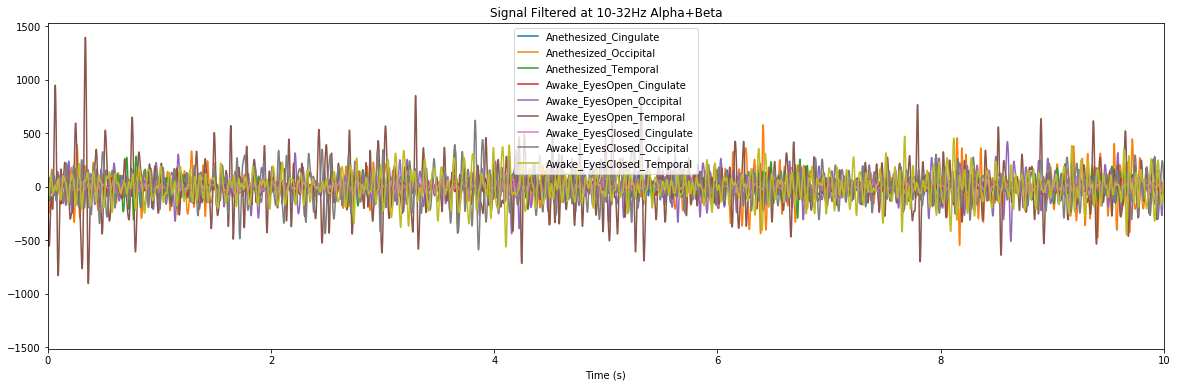

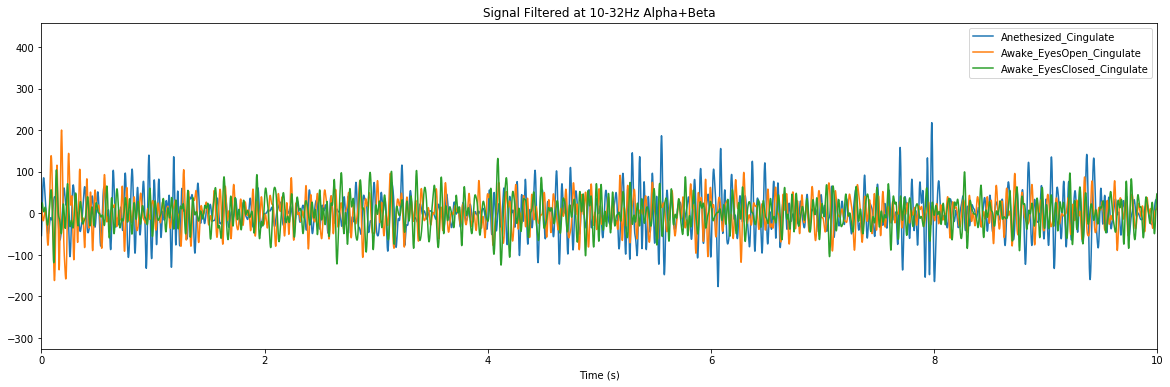

In [44]:
band = [10,32]
fir_anes_cin = monkey.band_pass_filter(monkey.signal(monkey.anes, 'cingulate'), band)
fir_anes_occ = monkey.band_pass_filter(monkey.signal(monkey.anes, 'occipital'), band)
fir_anes_tem = monkey.band_pass_filter(monkey.signal(monkey.anes, 'temporal'), band)

fir_eo_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'cingulate'), band)
fir_eo_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'occipital'), band)
fir_eo_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_open, 'temporal'), band)

fir_ec_cin = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'cingulate'), band)
fir_ec_occ = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'occipital'), band)
fir_ec_tem = monkey.band_pass_filter(monkey.signal(monkey.eyes_closed, 'temporal'), band)


signals = list([fir_anes_cin, fir_anes_occ, fir_anes_tem,
                          fir_eo_cin, fir_eo_occ, fir_eo_tem,
                          fir_ec_cin, fir_ec_occ, fir_ec_tem])
labels = ['Anethesized_Cingulate', 'Anethesized_Occipital', 'Anethesized_Temporal',
                     'Awake_EyesOpen_Cingulate', 'Awake_EyesOpen_Occipital', 'Awake_EyesOpen_Temporal',
                     'Awake_EyesClosed_Cingulate', 'Awake_EyesClosed_Occipital', 'Awake_EyesClosed_Temporal']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 10-32Hz Alpha+Beta")



signals = list([fir_anes_cin, fir_eo_cin, fir_ec_cin])
labels = ['Anethesized_Cingulate', 'Awake_EyesOpen_Cingulate', 'Awake_EyesClosed_Cingulate']
monkey.plot_signals(signals, labels, x_range=[0,10])
plt.title("Signal Filtered at 10-32Hz Alpha+Beta")



### Analytic Power over Time

Text(0.5,1,'Averge of Power Means')

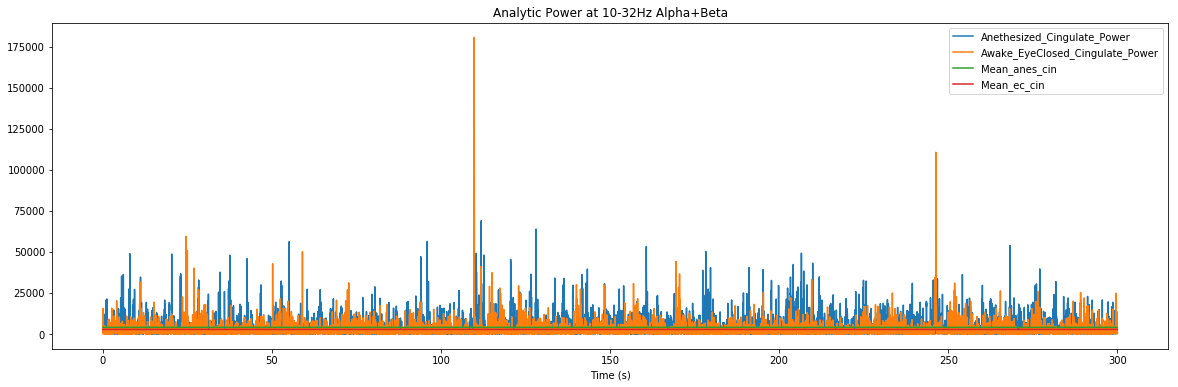

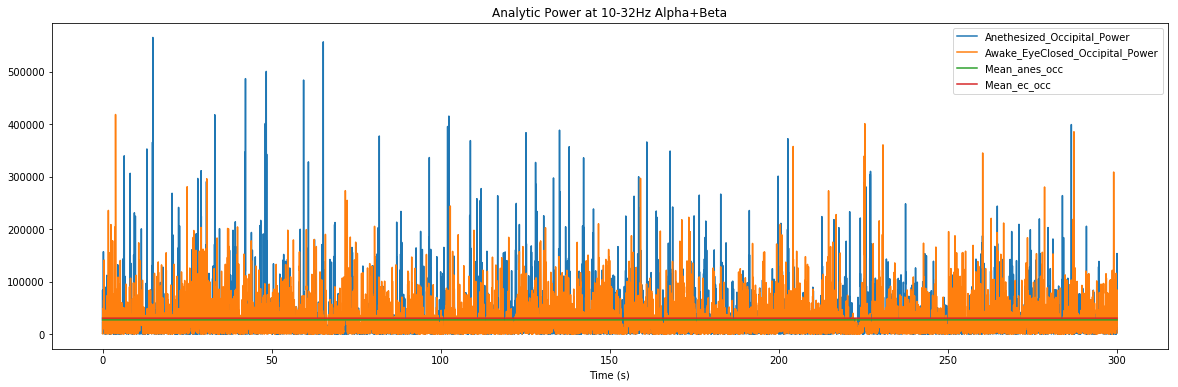

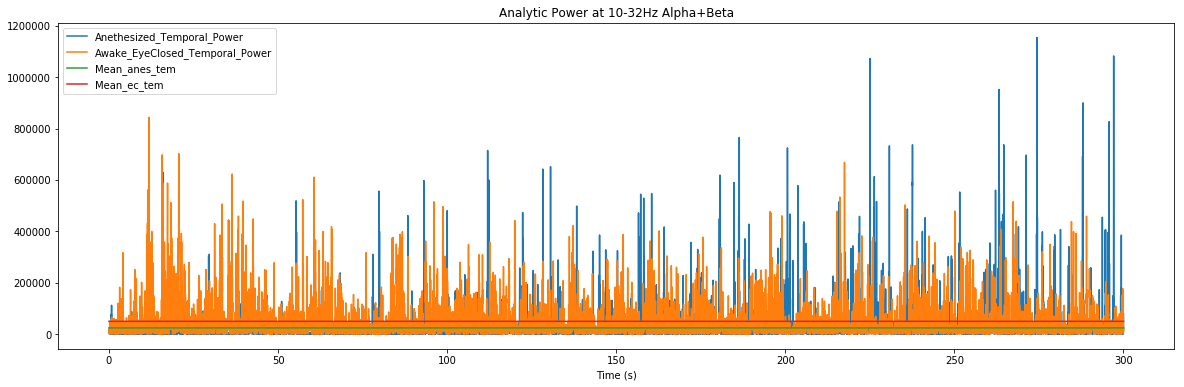

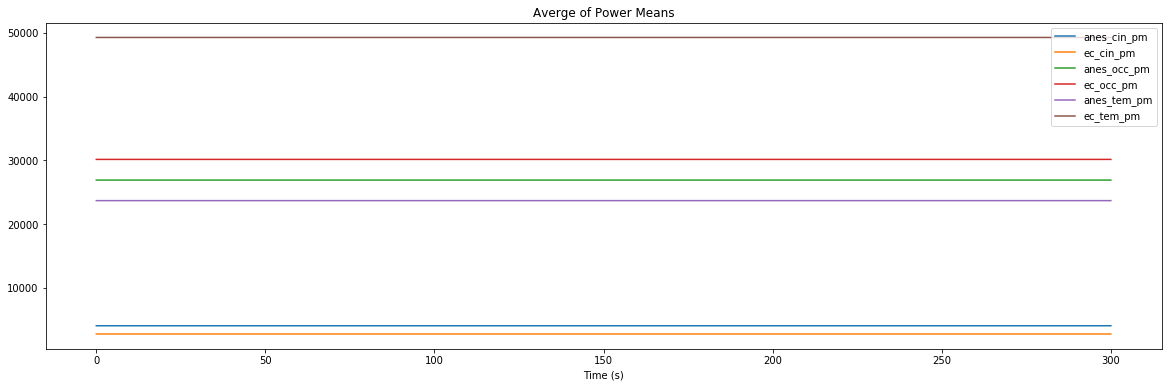

In [45]:
# Power over time (Hilbert)

anes_cin_analytic = signal.hilbert(fir_anes_cin)
anes_cin_power, anes_cin_phase = ECoG_data.compute_power_phase(anes_cin_analytic)
ec_cin_analytic = signal.hilbert(fir_ec_cin)
ec_cin_power, ec_cin_phase = ECoG_data.compute_power_phase(ec_cin_analytic)

anes_occ_analytic = signal.hilbert(fir_anes_occ)
anes_occ_power, anes_occ_phase = ECoG_data.compute_power_phase(anes_occ_analytic)
ec_occ_analytic = signal.hilbert(fir_ec_occ)
ec_occ_power, ec_occ_phase = ECoG_data.compute_power_phase(ec_occ_analytic)

anes_tem_analytic = signal.hilbert(fir_anes_tem)
anes_tem_power, anes_tem_phase = ECoG_data.compute_power_phase(anes_tem_analytic)
ec_tem_analytic = signal.hilbert(fir_ec_tem)
ec_tem_power, ec_tem_phase = ECoG_data.compute_power_phase(ec_tem_analytic)


#monkey.plot_signal("Anethesized_Cingulate_Power", power)#, x_range=[0,10], y_range=[0,300000])

anes_cin_pm = np.repeat(anes_cin_power.mean(), len(anes_cin_power))
ec_cin_pm = np.repeat(ec_cin_power.mean(), len(ec_cin_power))
sigs = list([anes_cin_power, ec_cin_power, anes_cin_pm, ec_cin_pm]) 
labels = ['Anethesized_Cingulate_Power', 'Awake_EyeClosed_Cingulate_Power', 'Mean_anes_cin', 'Mean_ec_cin']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 10-32Hz Alpha+Beta")



anes_occ_pm = np.repeat(anes_occ_power.mean(), len(anes_occ_power))
ec_occ_pm = np.repeat(ec_occ_power.mean(), len(ec_occ_power))
sigs = list([anes_occ_power, ec_occ_power, anes_occ_pm, ec_occ_pm])
labels = ['Anethesized_Occipital_Power', 'Awake_EyeClosed_Occipital_Power', 'Mean_anes_occ', 'Mean_ec_occ']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 10-32Hz Alpha+Beta")


anes_tem_pm = np.repeat(anes_tem_power.mean(), len(anes_tem_power))
ec_tem_pm = np.repeat(ec_tem_power.mean(), len(ec_tem_power))
sigs = list([anes_tem_power, ec_tem_power, anes_tem_pm, ec_tem_pm])
labels = ['Anethesized_Temporal_Power', 'Awake_EyeClosed_Temporal_Power', 'Mean_anes_tem', 'Mean_ec_tem']
monkey.plot_signals(sigs, labels)
plt.title("Analytic Power at 10-32Hz Alpha+Beta")



monkey.plot_signals(list([anes_cin_pm, ec_cin_pm, anes_occ_pm, ec_occ_pm, anes_tem_pm, ec_tem_pm]), 
                    labels = ['anes_cin_pm', 'ec_cin_pm', 'anes_occ_pm', 'ec_occ_pm', 'anes_tem_pm', 'ec_tem_pm'])
plt.title("Averge of Power Means")

### Frequency over time (derivative of phase)

Text(0,0.5,'Frequency')

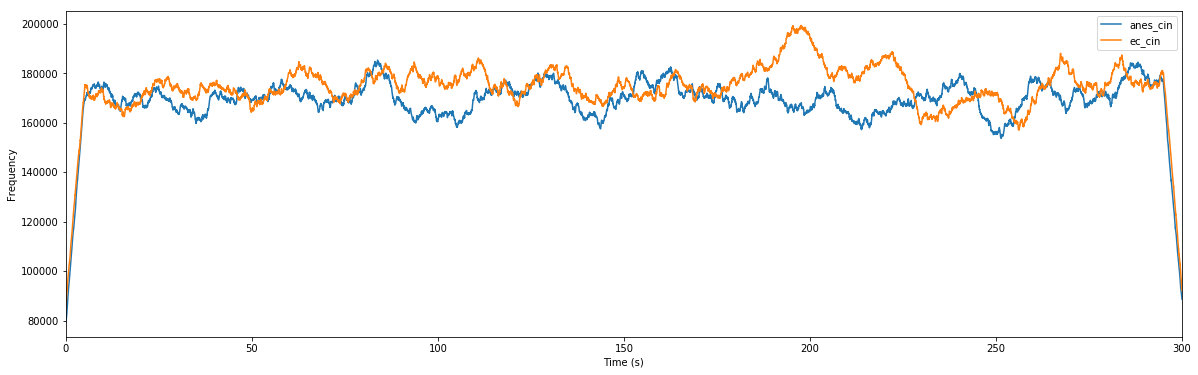

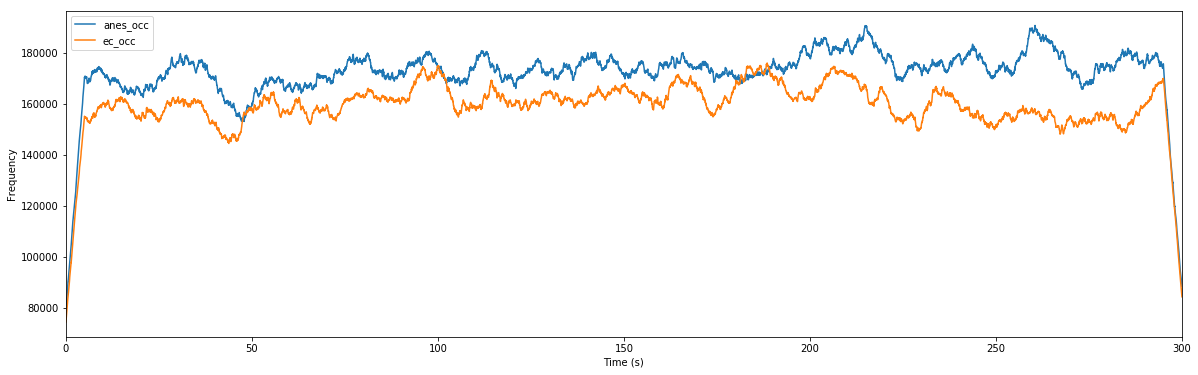

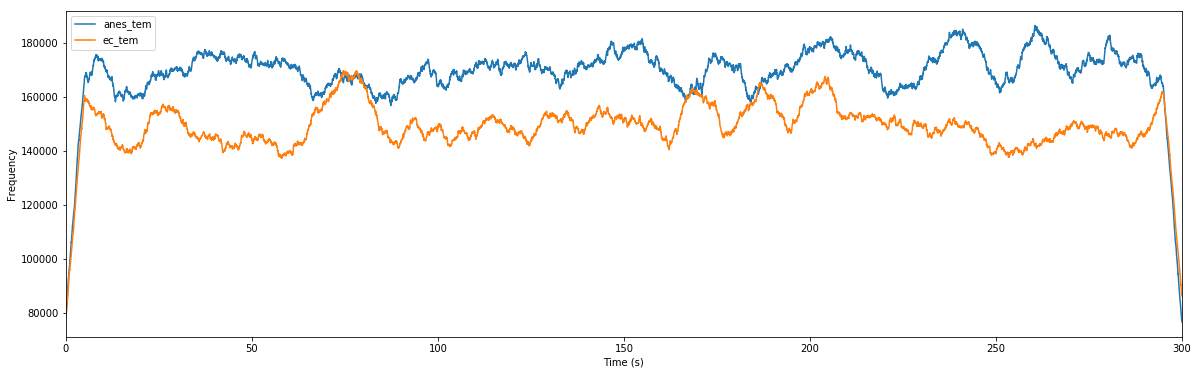

In [41]:
inst_freqs_anes_cin = np.append(np.diff(np.unwrap(anes_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_occ = np.append(np.diff(np.unwrap(anes_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_anes_tem = np.append(np.diff(np.unwrap(anes_tem_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_cin = np.append(np.diff(np.unwrap(ec_cin_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_occ = np.append(np.diff(np.unwrap(ec_occ_phase) / (2.0 * np.pi) * monkey.fs),0)
inst_freqs_ec_tem = np.append(np.diff(np.unwrap(ec_tem_phase) / (2.0 * np.pi) * monkey.fs),0)



sigs = [inst_freqs_anes_cin, inst_freqs_ec_cin]
labels = ['anes_cin','ec_cin']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_occ, inst_freqs_ec_occ]
labels = ['anes_occ','ec_occ']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")


sigs = [inst_freqs_anes_tem, inst_freqs_ec_tem]
labels = ['anes_tem','ec_tem']
boxcar_win = signal.boxcar( 10 * monkey.fs)
sigs_filtered = []
for sig in sigs:
    sigs_filtered.append(np.convolve(sig, boxcar_win, mode='same'))
monkey.plot_signals(sigs_filtered, labels, x_range = [0,300], y_range = None)
plt.ylabel("Frequency")
